In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, shapiro, gaussian_kde

# Preprocesamiento del dataset para predicción de géneros musicales

### Índice
1. Introducción
2. Carga y limpieza
3. Visualización
    1. Estudio con hipótesis sobre la escala
    2. Visualización de los atributos con valores nulos
    3. Visualización de los atributos restantes
4. Tratamiento de duplicados
5. Tratamiento de nulos

### 1. Introducción

En este cuaderno se realizará el proceso de carga, limpieza, visualización y tareas específicas de preprocesamiento del dataset en cuestión. Este dataset contiene información de canciones pertenecientes a diferentes géneros musicales. Los géneros presentes en el dataset son 'Electronic', 'Anime', 'Jazz', 'Alternative', 'Country', 'Rap', 'Blues', 'Rock', 'Classical', 'Hip-Hop'. Aunque como veremos finalmente esta lista de géneros será ampliada. El objetivo principal de este cuaderno es estudiar y resolver los problemas de preprocesamiento que nos encontremos para posteriormente poder tener un punto de partida estable en el procesamiento.

El dataset puede ser obtenido en [este enlace](https://www.kaggle.com/datasets/vicsuperman/prediction-of-music-genre) y utiliza datos de la API de Spotify.

A continuación, se van a explicar las diferentes columnas del dataset.
- instance_id: ID de la instancia.
- artist_name: Nombre del artista.
- track_name: Nombre de la canción.
- popularity: Popularidad de la canción. El valor está en el rango 0-100, siendo 100 la más popular.
- acousticness: Confianza de 0 a 1 de que una canción sea acústica, es decir, que está creada utilizando principalmente instrumentos que generan sonido sin necesidad de amplificación eléctrica o electrónica, como guitarras acústicas, pianos o violines. Un 1 representa una alta confianza de que la canción sea acústica, mientras que un valor bajo indica que es más probable que se hayan utilizado instrumentos electrónicos o amplificados.
- danceability: Variable que mide de 0 a 1 qué tan bailable es una canción basándose en características como el tempo, la estabilidad del ritmo o la fuerza del beat.
- duration_ms: Duración de la canción en milisegundos.
- energy: Medida de 0 a 1 que representa cómo de intensa se percibe una canción. Por ejemplo, una canción de Rock tendría mucha energía, y un preludio de Bach tendría poca energía. 
- instrumentalness: Variable que predice de 0 a 1 si una canción contiene voces. Las canciones de rap o palabras cantadas se consideran sonidos vocales, y onomatopeyas se consideran instrumentales. Mayores valores indican una mayor probabilidad de que una canción sea puramete instrumental.
- key: Escala musical representado en notación anglosajona. Por ejemplo: Do = C, Do♯/Re♭ = C♯/D♭, Re= D, 
- liveness: Índice (0 a 1) que estima si la canción fue grabada en vivo. Valores altos sugieren una mayor probabilidad de que la grabación sea en directo.
- loudness: Intensidad de la canción en decibelios (dB). Los valores típicos son entre -60 y 0 dB. 
- mode: Indica la modalidad (Mayor o menor) de una canción. Mayor se representa como 1 y menor como 0.
- speechiness: Medida de 0 a 1 que detecta la presencia de palabras habladas en la canción. Cuanto más cercana sea a un discurso (audiolibros, podcasts...) más cercano a 1 será el valor. Valores entre 0.33 y 0.66 indican que hay tanto música como discurso. Y valores por debajo de 0.33 representan más a música y otro tipo de contenido sin discursos.
- tempo: Velocidad estimada de una canción en beats por minuto (BPM).
- obtained_date: Fecha en la que se obtuvo la instancia de la API de Spotify.
- valence: Medida de 0 a 1 que indica la positividad que transmite una canción. Canciones con un valor alto transmiten sentimientos más positivos (felicidad, euforia...) y canciones con valor bajo transmiten sentimientos más negativos (tristeza, enfado...).
- music_genre: Género musical al que pertenece la canción. Los posibles valores son 'Electronic', 'Anime', 'Jazz', 'Alternative', 'Country', 'Rap', 'Blues', 'Rock', 'Classical', 'Hip-Hop'.

### 2. Carga y limpieza

Como primer paso se carga el dataset tal cual se ha descargado, y visualizamos sus primeras filas para hacernos una idea de su estructura.

In [2]:
music_df = pd.read_csv('music_genre.csv')
print(music_df.head())

   instance_id           artist_name            track_name  popularity  \
0      32894.0              Röyksopp  Röyksopp's Night Out        27.0   
1      46652.0  Thievery Corporation      The Shining Path        31.0   
2      30097.0        Dillon Francis             Hurricane        28.0   
3      62177.0              Dubloadz                 Nitro        34.0   
4      24907.0           What So Not      Divide & Conquer        32.0   

   acousticness  danceability  duration_ms  energy  instrumentalness key  \
0       0.00468         0.652         -1.0   0.941           0.79200  A#   
1       0.01270         0.622     218293.0   0.890           0.95000   D   
2       0.00306         0.620     215613.0   0.755           0.01180  G#   
3       0.02540         0.774     166875.0   0.700           0.00253  C#   
4       0.00465         0.638     222369.0   0.587           0.90900  F#   

   liveness  loudness   mode  speechiness               tempo obtained_date  \
0     0.115    -5.2

Hay una columna que no nos será necesaria en ningún momento, que es la fecha de introducción del dato al dataset.

In [3]:
# Drop obtained_date column -> seems to be the date added to the dataset
music_df = music_df.drop('obtained_date', axis=1)

Vamos a ver cuántos datos tenemos para cada género.

In [4]:
# Check target column shape
print(music_df['music_genre'].value_counts())

music_genre
Electronic     5000
Anime          5000
Jazz           5000
Alternative    5000
Country        5000
Rap            5000
Blues          5000
Rock           5000
Classical      5000
Hip-Hop        5000
Name: count, dtype: int64


Como se puede observar, la cantidad de canciones con cada género está equilibrada. Esto puede ayudarnos para evitar que haya géneros con mayor presencia en los datos, y por lo tanto esos géneros se vean beneficiados a la hora de la clasificación.

A continuación, vamos a ver si hay valores nulos.

In [5]:
# Check for missing values
print(music_df.isnull().sum())

# Show them
print(music_df[music_df.isnull().any(axis=1)])

instance_id         5
artist_name         5
track_name          5
popularity          5
acousticness        5
danceability        5
duration_ms         5
energy              5
instrumentalness    5
key                 5
liveness            5
loudness            5
mode                5
speechiness         5
tempo               5
valence             5
music_genre         5
dtype: int64
       instance_id artist_name track_name  popularity  acousticness  \
10000          NaN         NaN        NaN         NaN           NaN   
10001          NaN         NaN        NaN         NaN           NaN   
10002          NaN         NaN        NaN         NaN           NaN   
10003          NaN         NaN        NaN         NaN           NaN   
10004          NaN         NaN        NaN         NaN           NaN   

       danceability  duration_ms  energy  instrumentalness  key  liveness  \
10000           NaN          NaN     NaN               NaN  NaN       NaN   
10001           NaN          NaN

Ha sido el caso, había 5 filas completamente vacías, y las vamos a eliminar.

In [6]:
#  5 rows with missing values in the dataset, drop them
music_df = music_df.dropna(how='all')

Ahora vamos a observar los tipos que le ha asignado pandas a cada columna para comprobar que son correctos.

In [7]:
# Check column types read by pandas -> tempo column is object...
print(music_df.dtypes)

instance_id         float64
artist_name          object
track_name           object
popularity          float64
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
key                  object
liveness            float64
loudness            float64
mode                 object
speechiness         float64
tempo                object
valence             float64
music_genre          object
dtype: object


Como observamos, la columna tempo se detecta como object, es decir, como si fuera de tipo string. Asimismo, las columnas que queremos que sean categóricas habrá que preprocesarlas más adelante. De momento vamos a estudiar qué ocurre con la columna tempo, ya que debería ser de tipo float.

In [8]:
# Check what happens with the tempo column --> should be float but is object
print(music_df['tempo'].head())

0               100.889
1    115.00200000000001
2               127.994
3               128.014
4               145.036
Name: tempo, dtype: object


Viendo la cabecera, comprobamos que el tipo es efectivamente object, pero no podemos visualizar qué está produciendo esto, así que vamos a hacer un estudio intentando convertir a float los valores, y aquellos que no puedan ser convertidos los guardamos.

In [9]:
# Check which values can and cannot be converted to float
conversions = {
    'can': [],
    'cannot': []
}
for i in music_df['tempo']:
    try:
        float(i)
        conversions['can'].append(i)
    except ValueError:
        conversions['cannot'].append(i)

print(len(conversions.get('cannot')))
print(np.unique(conversions.get('cannot')))

4980
['?']


Podemos ver que todos los valores que no han podido ser convertidos (4980) son un signo de interrogación: '?'.

Vamos a reemplazar este signo de interrogación por un valor vacío, para que sea más fácil manejarlos más adelante.

In [10]:
# All non convertible values are '?', replace them with NaN --> later we will see how to handle them
music_df['tempo'] = music_df['tempo'].replace('?', np.nan)

# Convert tempo column to float
music_df['tempo'] = music_df['tempo'].astype(float)

print(music_df['tempo'].head())

0    100.889
1    115.002
2    127.994
3    128.014
4    145.036
Name: tempo, dtype: float64


Observando el csv, nos hemos dado cuenta de que algunos valores de duración son -1, lo que entendemos que indica que no se ha podido encontrar la duración al extraer los datos. Por lo tanto, vamos a realizar la misma operación que anteriormente.

In [11]:
# Also, in the duration column, a -1 is placed when no data could be retrieved
music_df['duration_ms'] = music_df['duration_ms'].replace(-1.0, np.nan)

Ahora que hemos hecho un poco de limpieza sobre el dataset, vamos a mostrar algunas métricas (asegurando así que los datos son ahora correctos) y a guardar el nuevo dataframe como punto de control.

In [12]:
# Describe the dataset
print(music_df.describe())

        instance_id    popularity  acousticness  danceability   duration_ms  \
count  50000.000000  50000.000000  50000.000000  50000.000000  4.506100e+04   
mean   55888.396360     44.220420      0.306383      0.558241  2.455035e+05   
std    20725.256253     15.542008      0.341340      0.178632  1.114333e+05   
min    20002.000000      0.000000      0.000000      0.059600  1.550900e+04   
25%    37973.500000     34.000000      0.020000      0.442000  1.904670e+05   
50%    55913.500000     45.000000      0.144000      0.568000  2.273600e+05   
75%    73863.250000     56.000000      0.552000      0.687000  2.756800e+05   
max    91759.000000     99.000000      0.996000      0.986000  4.830606e+06   

             energy  instrumentalness      liveness      loudness  \
count  50000.000000      50000.000000  50000.000000  50000.000000   
mean       0.599755          0.181601      0.193896     -9.133761   
std        0.264559          0.325409      0.161637      6.162990   
min        0

In [13]:
# Now we can save the cleaned dataset to a new csv file
music_df.to_csv('cleaned_music_genre.csv', index=False)

### 3. Visualización

#### 3.1 Estudio con hipótesis sobre la escala

Una de las cosas que nos llamó la atención para estudiar primero y más a fondo fue la importancia de las escalas en la predicción de géneros musicales. A priori, la escala (sin tener en cuenta el modo, es decir, si es mayor o menor) no debería tener un impacto significativo en el género de una canción, ya que la selección de la escala suele ser una elección del compositor y no una característica intrínseca del género. De hecho, cualquier canción puede cambiar de escala mediante un proceso conocido como transposición, sin alterar su estructura musical ni su asociación con un género particular.

Sin embargo, si observamos que la escala influye en los resultados de la predicción más de lo esperado, esto podría deberse a varios factores. Por un lado, los datos utilizados para entrenar el modelo podrían contener patrones estadísticos asociados con ciertas escalas que no reflejan una relación musical real, sino un sesgo en la recopilación de los datos. Por otro lado, las diferencias en el timbre, la textura, o la instrumentación típica de ciertos géneros podrían coincidir indirectamente con ciertas escalas.

Para comenzar con este estudio, vamos a visualizar la distribución de las escalas de manera general y según el género

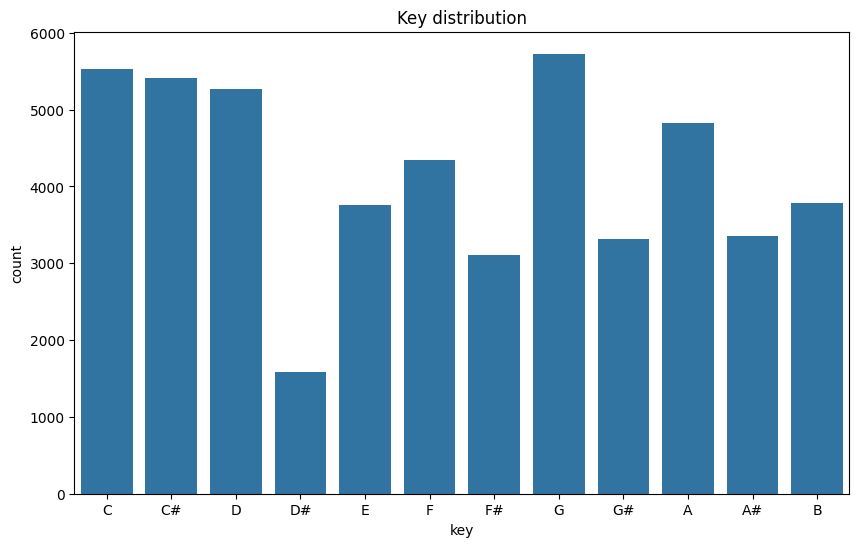

In [14]:
key_order = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

# One of the first things we want to visualize is the distribution of the key column, to see if it is relevant for the study
plt.figure(figsize=(10, 6))
sns.countplot(x='key', data=music_df, order=key_order)
plt.title('Key distribution')
plt.show()

Ya a simple vista podemos ver que hay diferencias significativas de canciones en cada escala. Vamos a ver la distribución según el género.

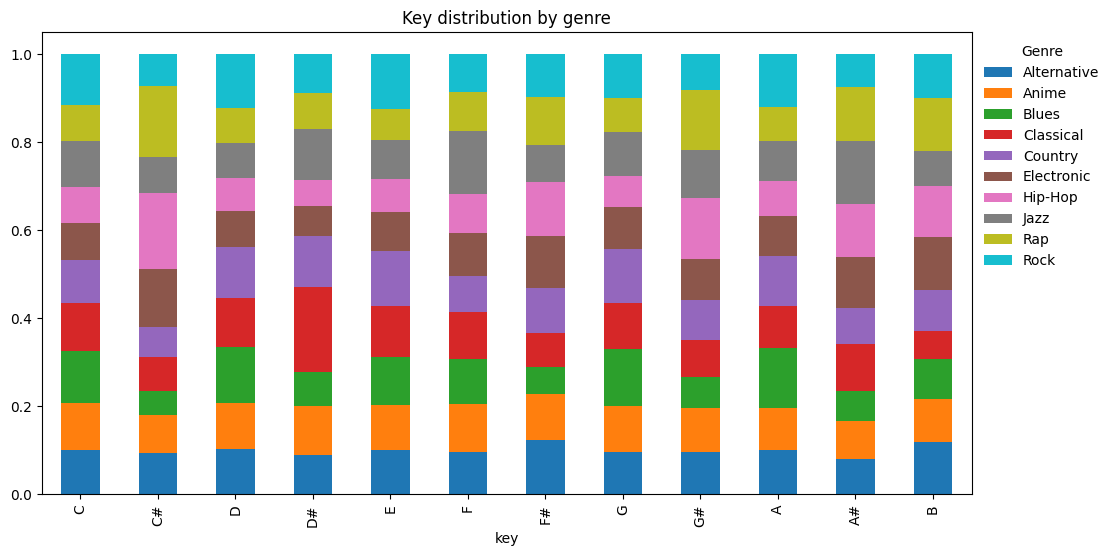

In [15]:
# Now we can visualize the distribution depending on the genre
key_genre_distribution = music_df.groupby('key')['music_genre'].value_counts(normalize=True).unstack()
key_genre_distribution = key_genre_distribution.reindex(key_order)
key_genre_distribution.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.legend(title='Genre', bbox_to_anchor=(1, 1), loc='upper left', frameon=False)
plt.title('Key distribution by genre')
plt.show()


Parece que hay géneros donde la distribución es más aleatoria o equitativa mientras que en otros se puede llegar a ver alguna preferencia. Por ello no podemos verificar visualmente nuestra hipótesis. Para estudiarlo de forma estadística vamos a ver la dependencia entre la escala y el género, usando el test chi cuadrado.

In [16]:
# Chi-square test to check if key and genre are independent
key_genre_contingency_table = pd.crosstab(music_df['key'], music_df['music_genre'])

chi2, p, dof, expected = chi2_contingency(key_genre_contingency_table)

print(f"Chi-squared: {chi2}")
print(f"P-value: {p}")
if p < 0.05:
    print("Existe una relación significativa entre 'key' y 'music_genre'.")
else:
    print("No existe una relación significativa entre 'key' y 'music_genre'.")


Chi-squared: 2420.652503437906
P-value: 0.0
Existe una relación significativa entre 'key' y 'music_genre'.


De forma algo inesperada nos demuestra que existe correlación entre la escala y el género, pero según nuestra hipótesis esta correlación debería ser débil. Para evaluar y cuantificar esta correlación, hemos utilizado la V de Cramer, una medida estadística que permite determinar la fuerza de la asociación entre dos variables categóricas.

In [17]:
def cramers_v(chi2, n, dof):
  return np.sqrt(chi2 / (n * min(dof, len(key_genre_contingency_table.columns) - 1)))

n = len(music_df)

cramers_v_value = cramers_v(chi2, n, dof)

print(f"Cramér's V: {cramers_v_value}")

Cramér's V: 0.07334321908273163


El resultado demuestra que la correlación es bastante débil. Aún así, al tener relación, este atributo no debería dejar de tenerse en cuenta.

#### 3.2 Visualización de los atributos con valores nulos
A partir de aquí nos centramos en visualizar la distribución y la media de cada atributo, de forma general y agrupando por género. Nos interesa, sobre todo ahora mismo, visualizar aquellos atributos que tienen valores nulos, para posteriormente tener claro que acción ejecutar. Actualmente las posibilidades que hemos pensado son eliminar filas con nulos, generar valores que siguen distribución normal según cada género o generar valores que sigan la distribución específica de cada género. Por ello nos interesa conocer la forma de la distribución de ambos atributos: tempo y duración.

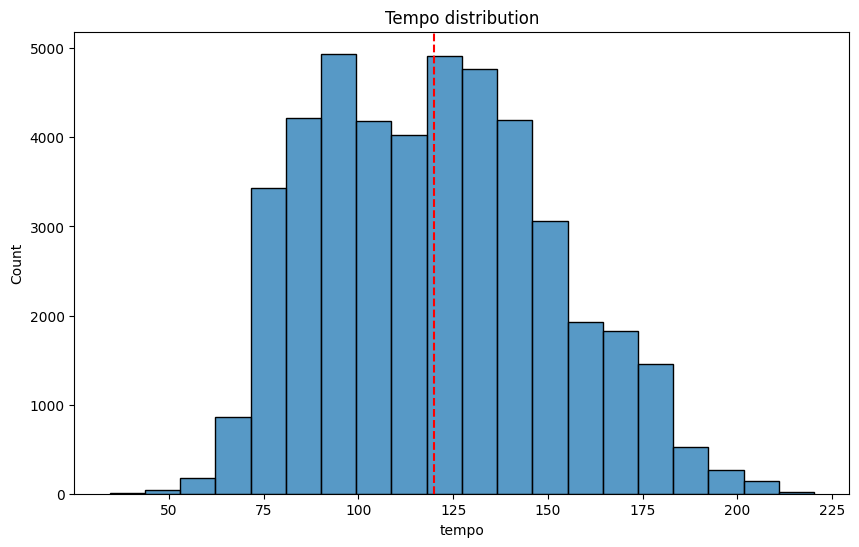

In [18]:
# Visualize the distribution of the tempo column
plt.figure(figsize=(10, 6))
sns.histplot(music_df['tempo'], bins=20)
plt.axvline(music_df['tempo'].mean(), color='red', linestyle='--', label='Mean')
plt.title('Tempo distribution')
plt.show()

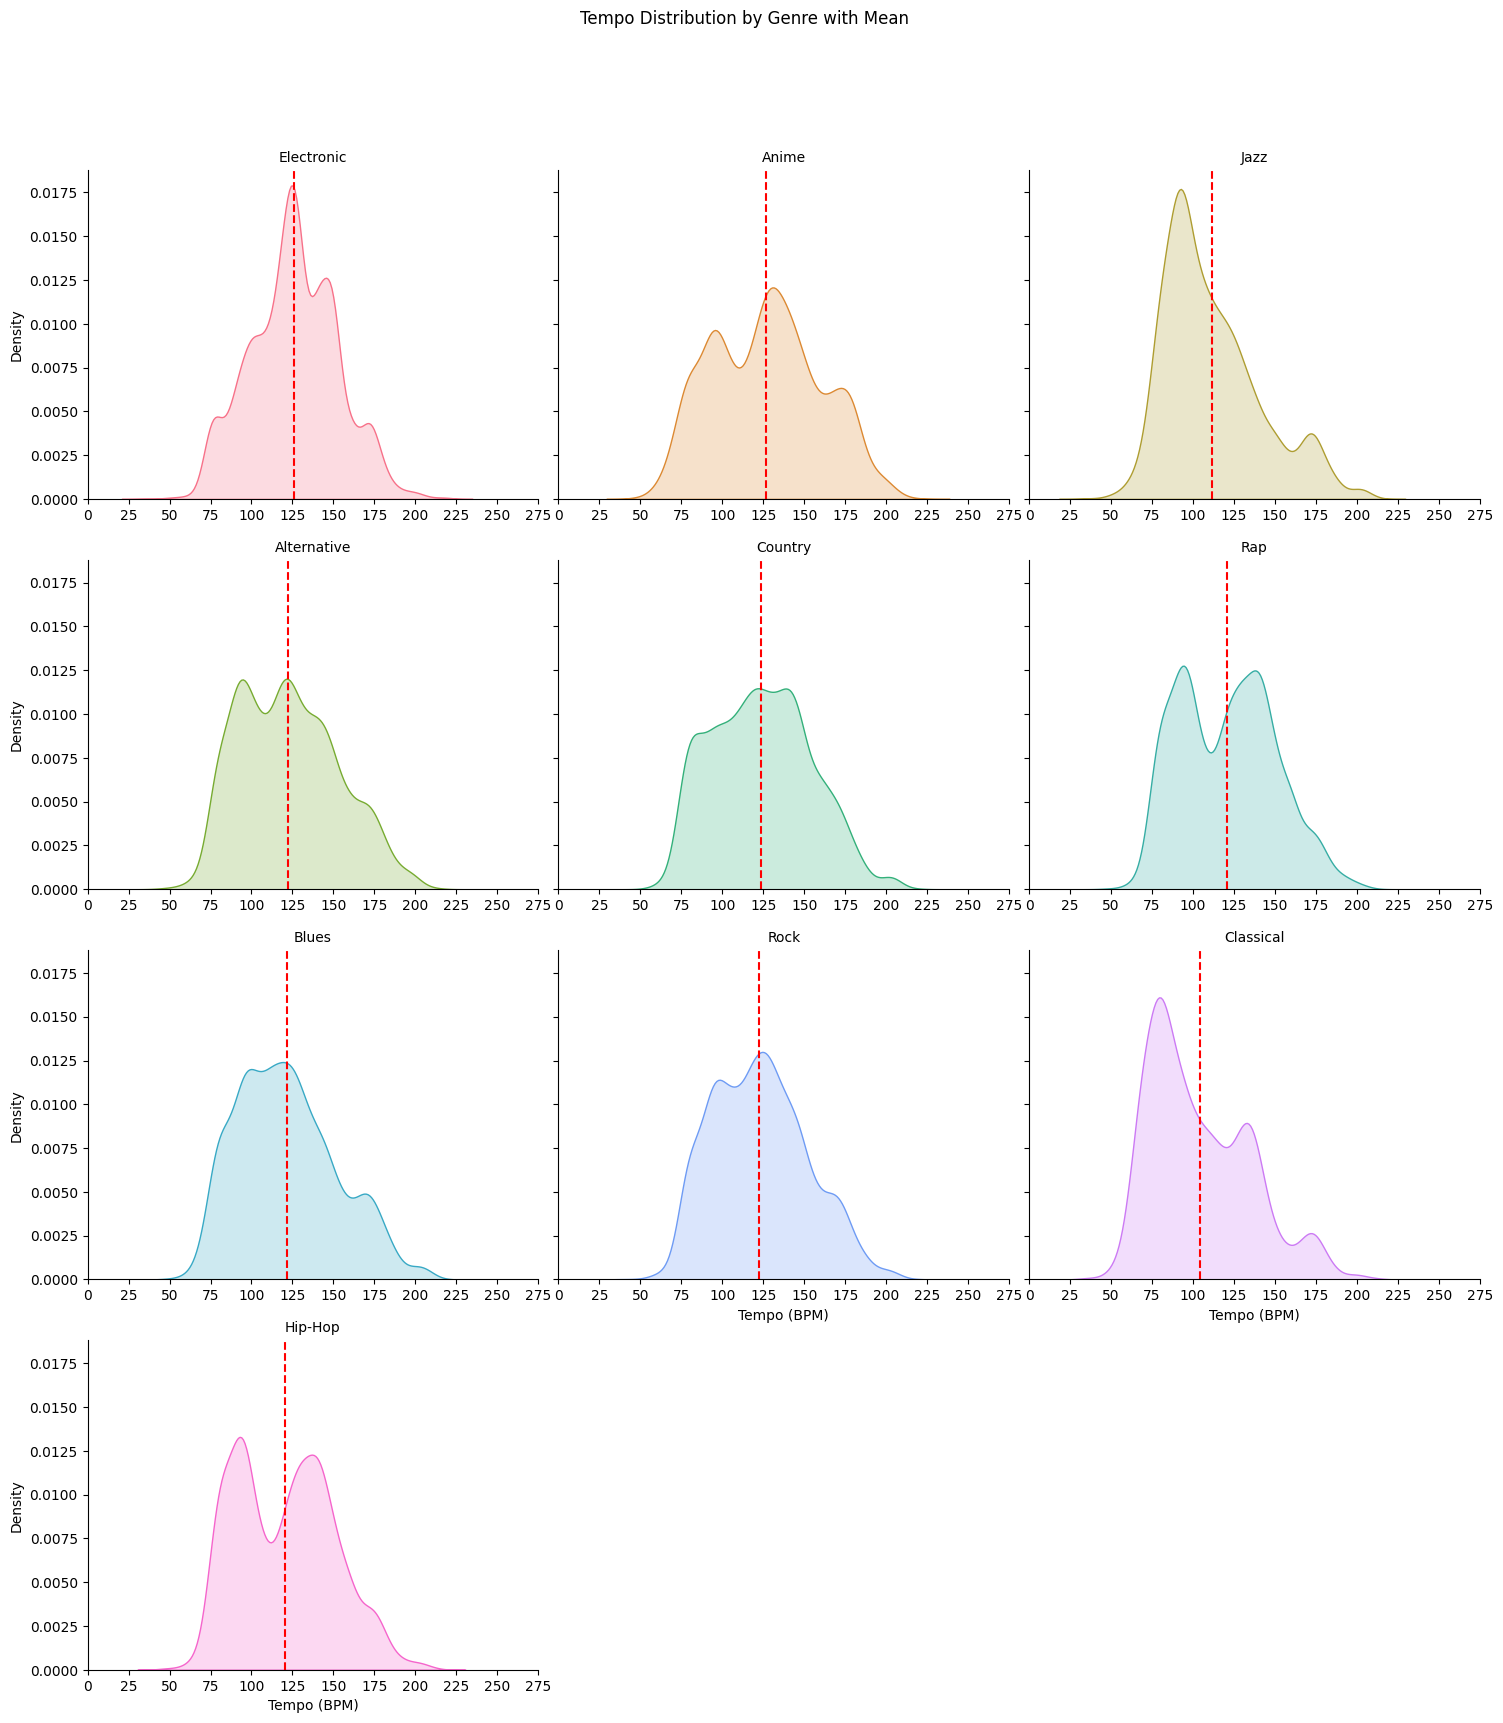

In [19]:
# Visualize the distribution of the tempo column depending on the genre
g = sns.FacetGrid(music_df, col="music_genre", col_wrap=3, height=5, sharex=False, sharey=True, hue="music_genre", palette="husl")


def add_kde_with_mean(data, **kwargs):
    sns.kdeplot(data=data, x="tempo", fill=True, **kwargs)
    plt.axvline(data["tempo"].mean(), color='red', linestyle='--', label='Mean')  

g.map_dataframe(add_kde_with_mean)

for ax in g.axes.flat:
  ax.set_xlim(0, 250)
  ax.set_xticks(range(0, 300, 25)) 

g.set_titles("{col_name}")
g.set_axis_labels("Tempo (BPM)", "Density")
plt.subplots_adjust(bottom=0.15, top=0.9) 
g.figure.suptitle('Tempo Distribution by Genre with Mean')
plt.show()

Se observa claramente (en algunos géneros más que en otros) que la distribución para nada es normal, por lo que para este atributo se descarta la opción correspondiente.

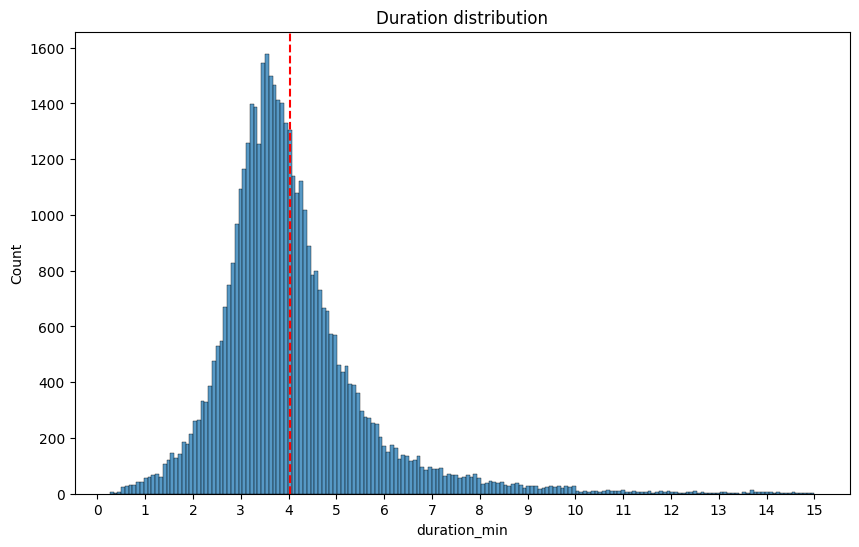

In [20]:
# Visualize durations distribution in minutes
duration_mins = music_df.copy()[['duration_ms', 'music_genre']]
duration_mins['duration_min'] = (duration_mins['duration_ms'] / 60000).round(2)

# Filter between 0 and 30 minutes
duration_mins['duration_min'] = duration_mins['duration_min'][(duration_mins['duration_min'] > 0) & (duration_mins['duration_min'] <=15)]

plt.figure(figsize=(10, 6))
sns.histplot(duration_mins['duration_min'])
plt.axvline(duration_mins['duration_min'].mean(), color='red', linestyle='--', label='Mean')
plt.title('Duration distribution')
plt.xticks(range(0, 16,1))
plt.show()


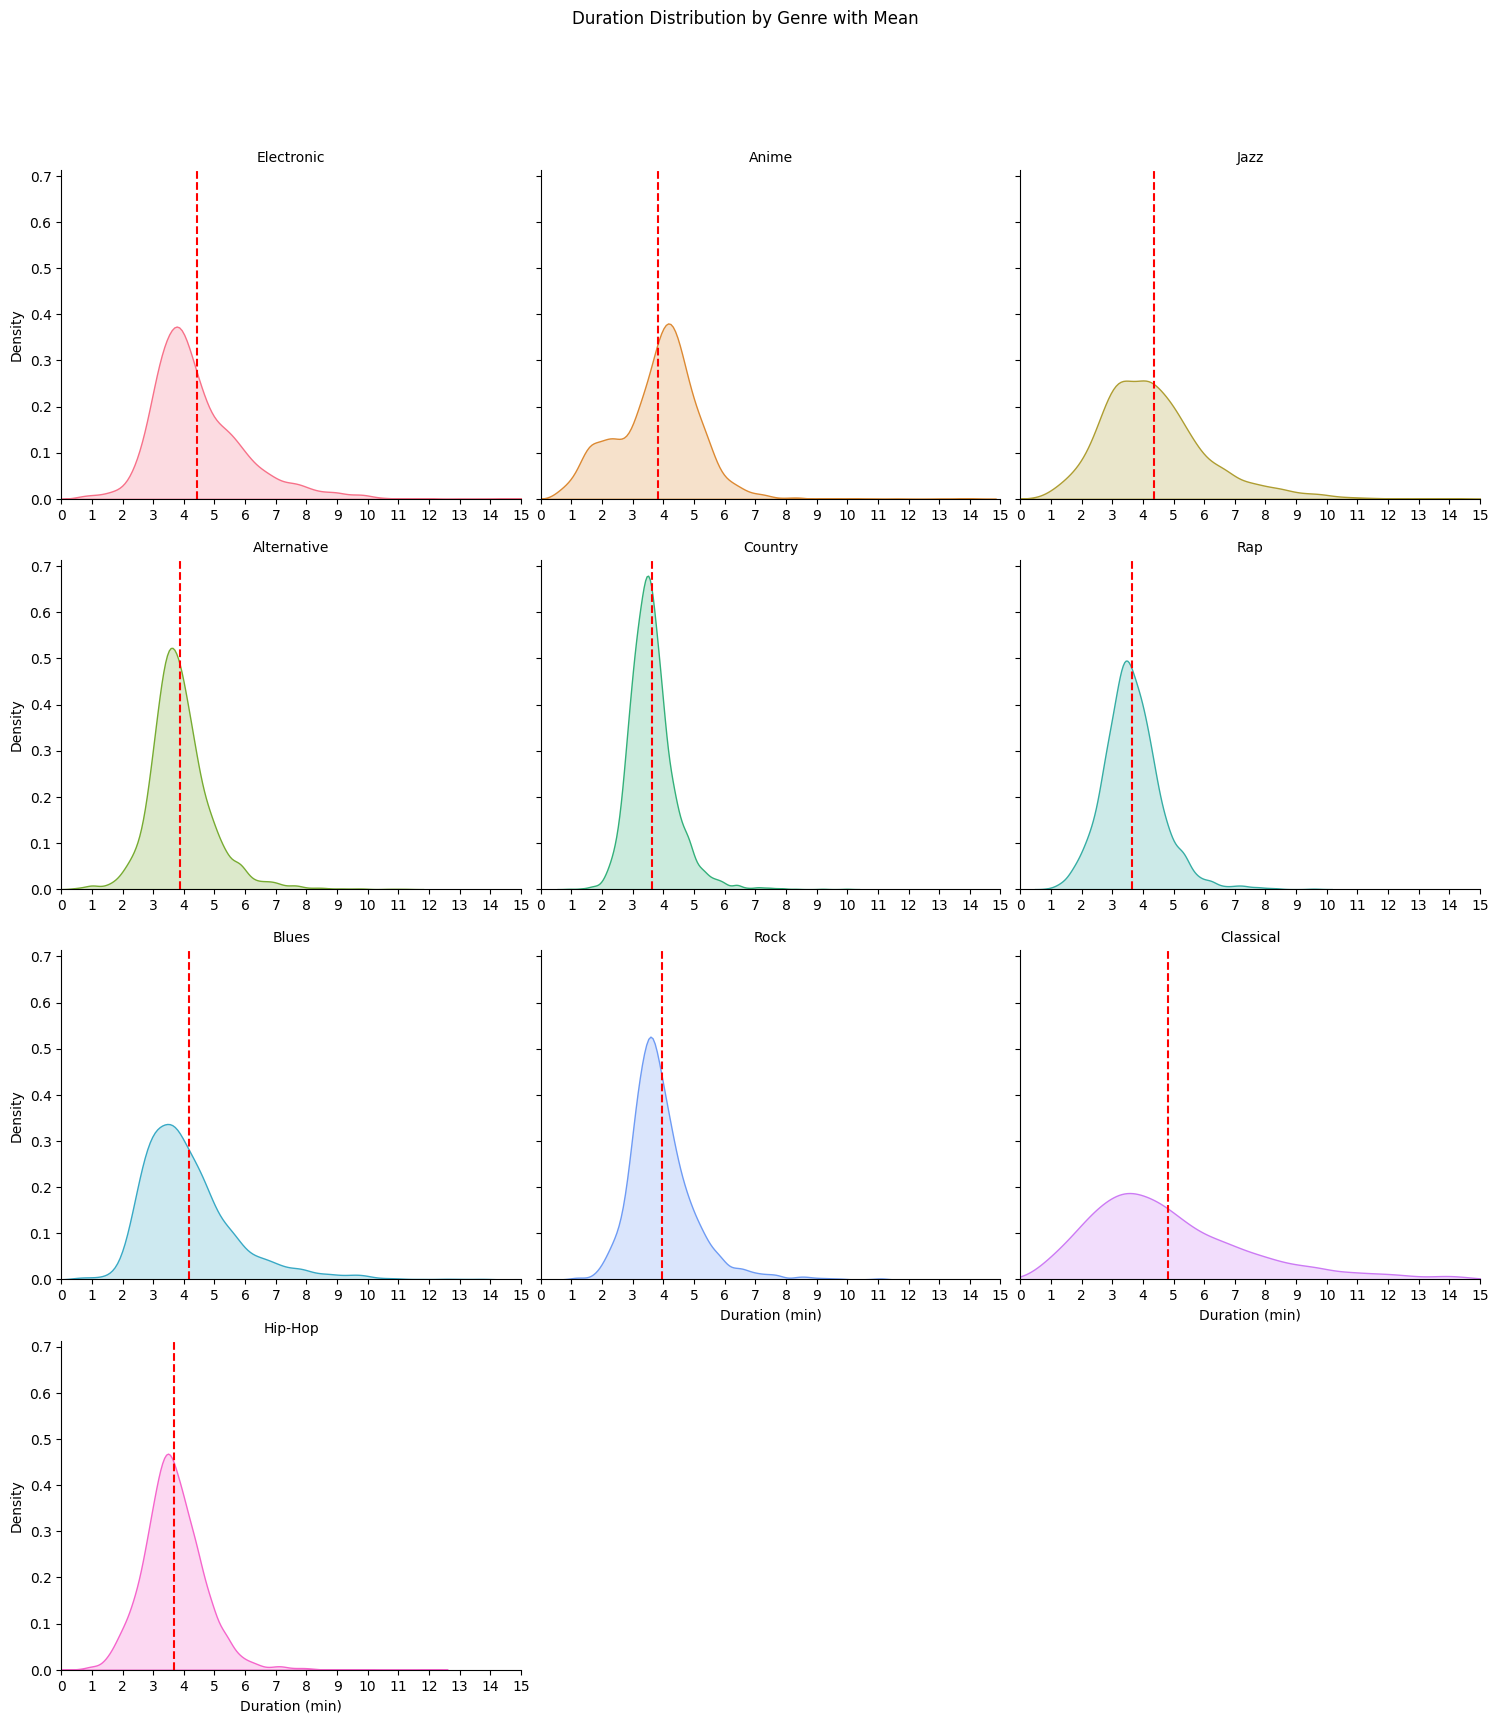

In [21]:
# Visualize the distribution of the duration column depending on the genre
g = sns.FacetGrid(duration_mins, col="music_genre", col_wrap=3, height=5, sharex=False, sharey=True, hue="music_genre", palette="husl")

def add_kde_with_mean(data, **kwargs):
    sns.kdeplot(data=data, x="duration_min", fill=True, **kwargs)
    plt.axvline(data["duration_min"].mean(), color='red', linestyle='--', label='Mean')
    
g.map_dataframe(add_kde_with_mean)

for ax in g.axes.flat:
  ax.set_xlim(0, 15)
  ax.set_xticks(range(0, 16, 1))
    
g.set_titles("{col_name}")
g.set_axis_labels("Duration (min)", "Density")
g.figure.suptitle('Duration Distribution by Genre with Mean')
plt.subplots_adjust(bottom=0.15, top=0.9) 

plt.show()

Aquí no está del todo claro si la mayoría de géneros seguiría una distribución normal, por ello más adelante habría que hacer un estudio a fondo.

#### 3.3 Visualización de los atributos restantes

A partir de aquí nos centramos en visualizar la distribución por género del resto de atributos, para si es posible extraer información relevante, como visualizar rápidamente atributos que tienen mayor diferencia entre géneros.

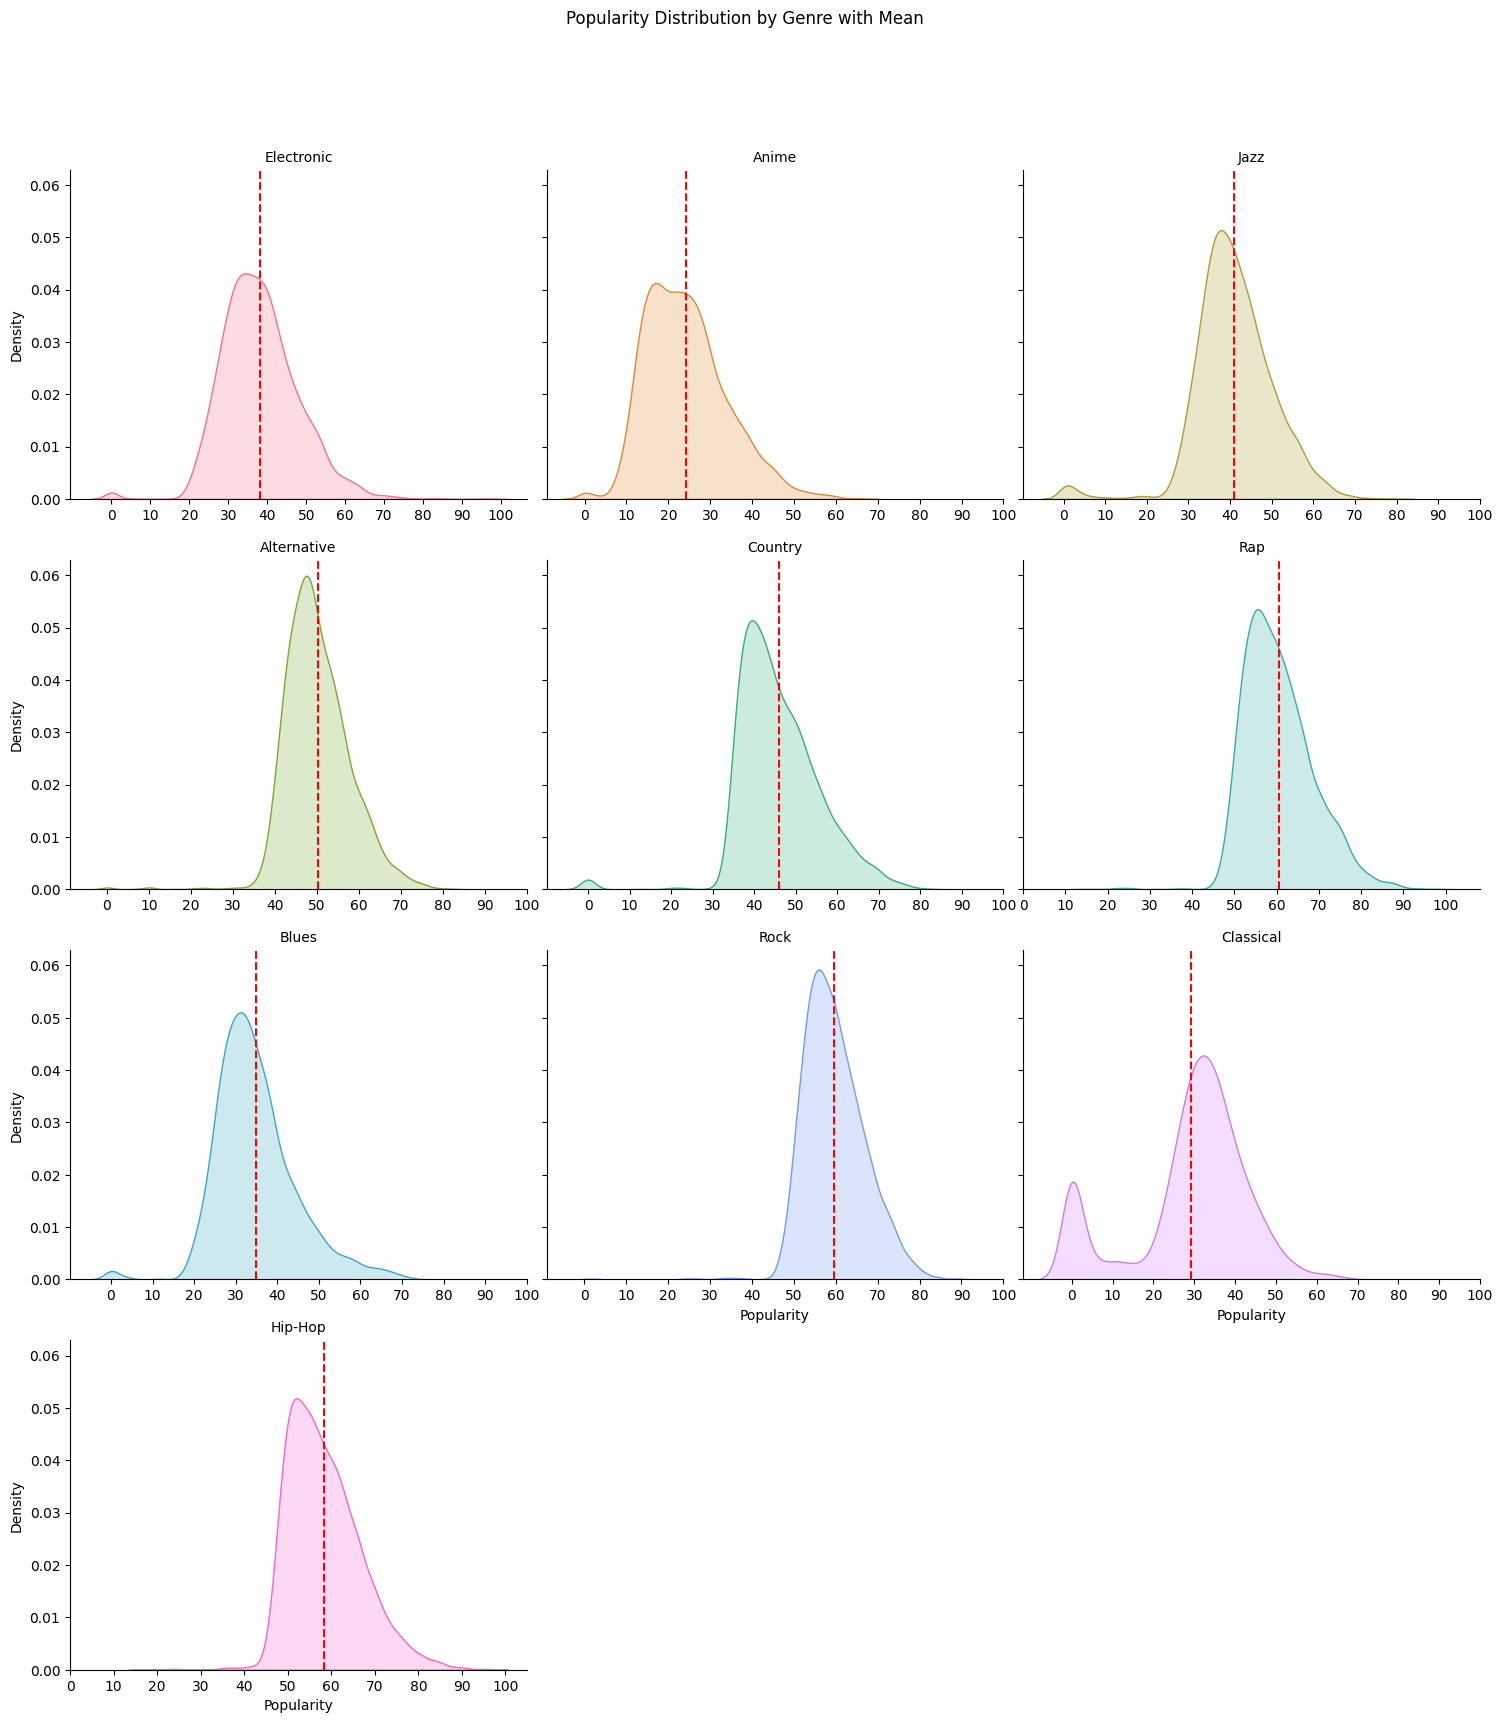

In [22]:
# Visualize the distribution of the popularity column depending on the genre
g = sns.FacetGrid(music_df, col="music_genre", col_wrap=3, height=5, sharex=False, sharey=True, hue="music_genre", palette="husl")


def add_kde_with_mean(data, **kwargs):
    sns.kdeplot(data=data, x="popularity", fill=True, **kwargs)
    plt.axvline(data["popularity"].mean(), color='red', linestyle='--', label='Mean')  

g.map_dataframe(add_kde_with_mean)

for ax in g.axes.flat:
  ax.set_xticks(range(0, 110, 10)) 

g.set_titles("{col_name}")
g.set_axis_labels("Popularity", "Density")
plt.subplots_adjust(bottom=0.15, top=0.9) 
g.figure.suptitle('Popularity Distribution by Genre with Mean')
plt.show()

Aquí se observa que hay bastante diferencia de popularidad entre algunos géneros.

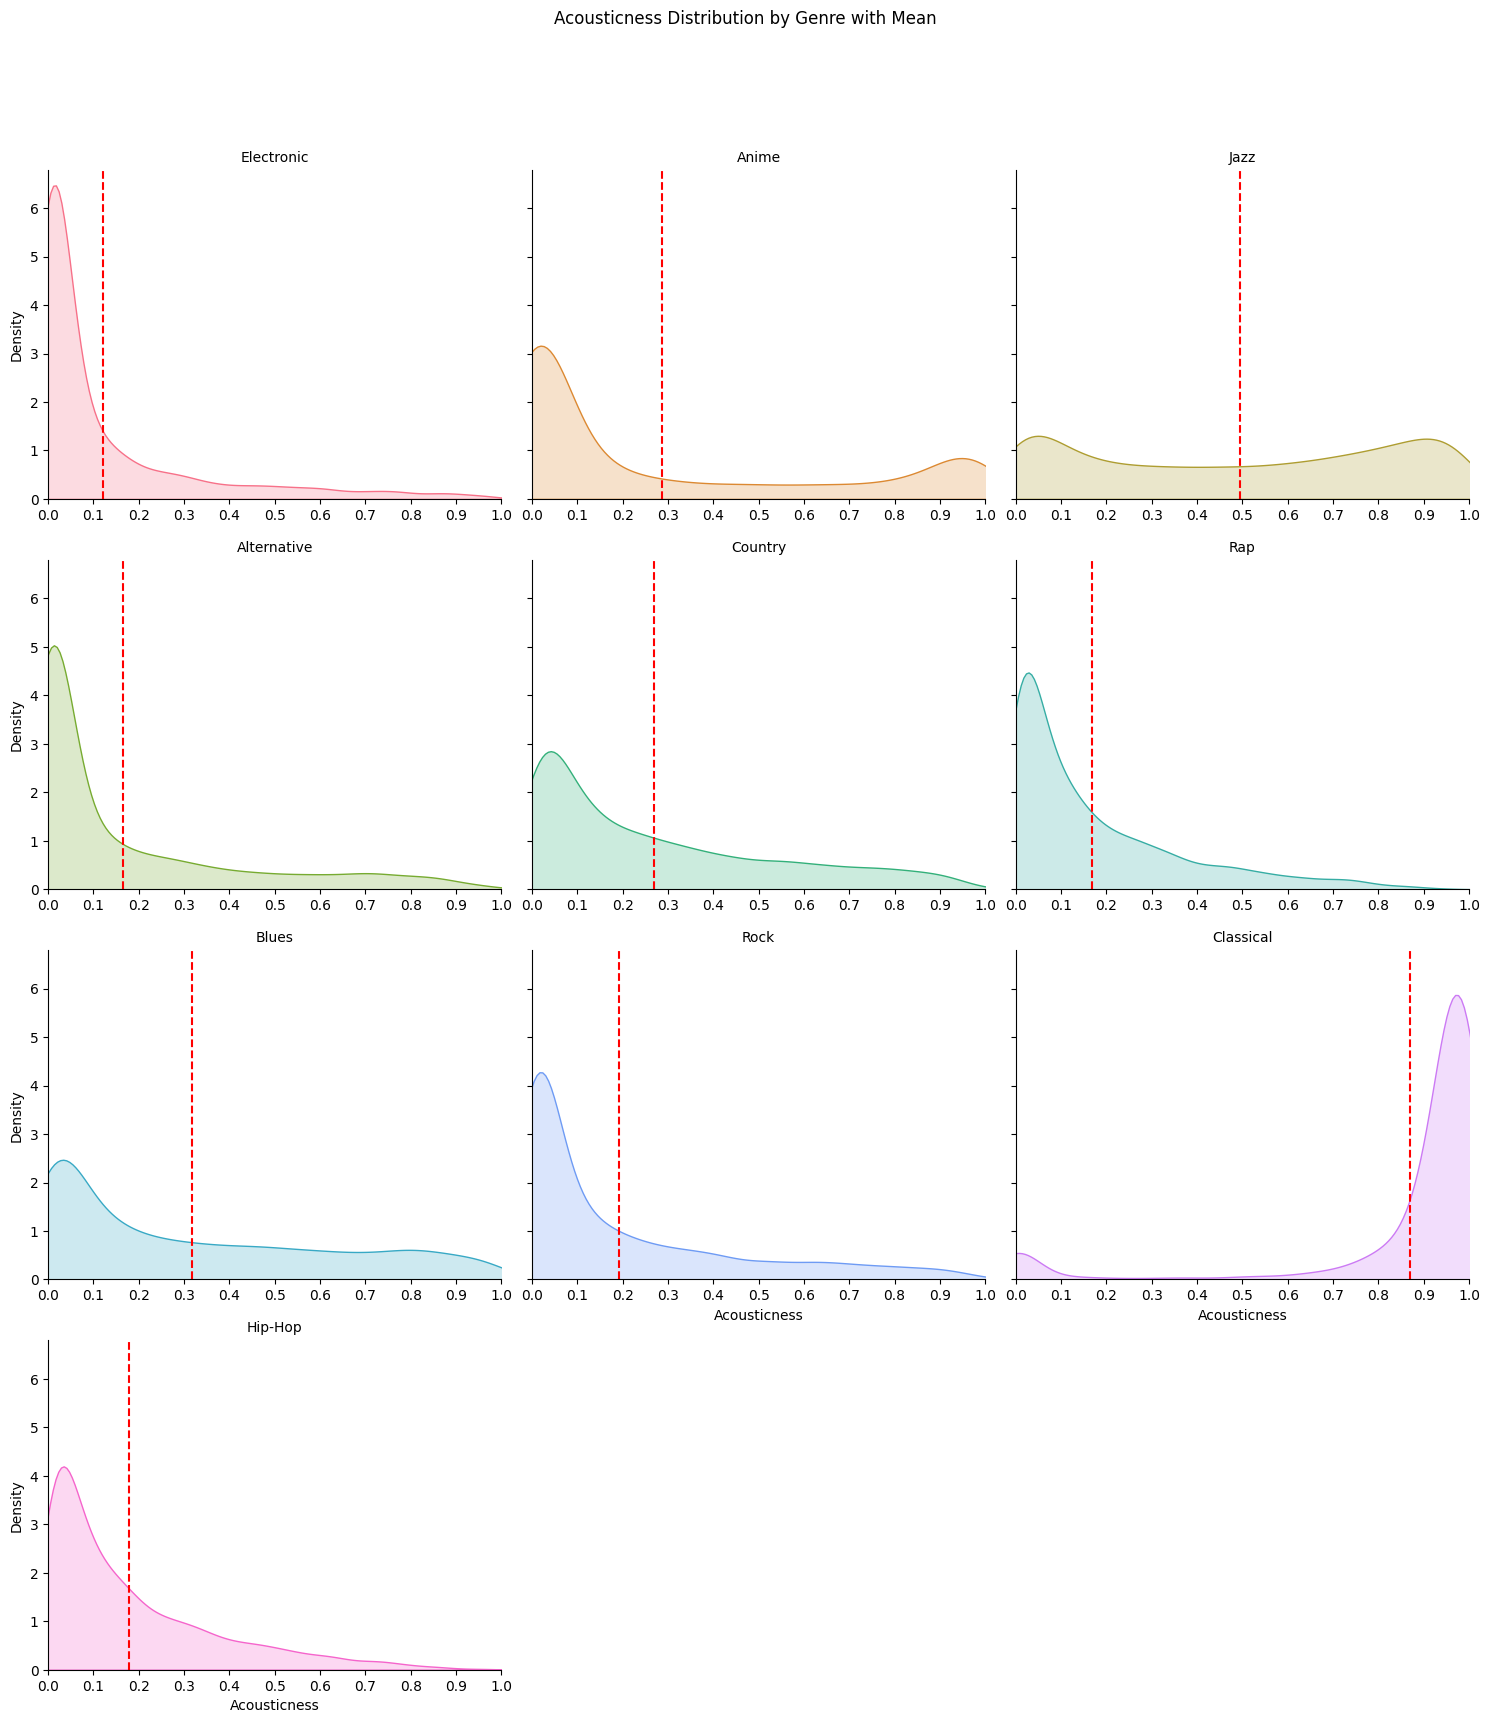

In [23]:
# Visualize the distribution of the acousticness column depending on the genre
g = sns.FacetGrid(music_df, col="music_genre", col_wrap=3, height=5, sharex=False, sharey=True, hue="music_genre", palette="husl")


def add_kde_with_mean(data, **kwargs):
    sns.kdeplot(data=data, x="acousticness", fill=True, **kwargs)
    plt.axvline(data["acousticness"].mean(), color='red', linestyle='--', label='Mean')  

g.map_dataframe(add_kde_with_mean)

for ax in g.axes.flat:
  ax.set_xlim(0, 1)
  ax.set_xticks(np.arange(0, 1.1, 0.1))

g.set_titles("{col_name}")
g.set_axis_labels("Acousticness", "Density")
plt.subplots_adjust(bottom=0.15, top=0.9) 
g.figure.suptitle('Acousticness Distribution by Genre with Mean')
plt.show()

Como es de esperar, la música clásica tiene un nivel de acusticidad máximo por el uso de instrumentos acústicos (sin otro tipo de procesamiento/efectos de audio). Le sigue el jazz con una distribución más dispersa. Por ejemplo, géneros con poco uso de instrumentos acústicos como la electrónica tienen la densidad muy elevada al acercarnos al 0.

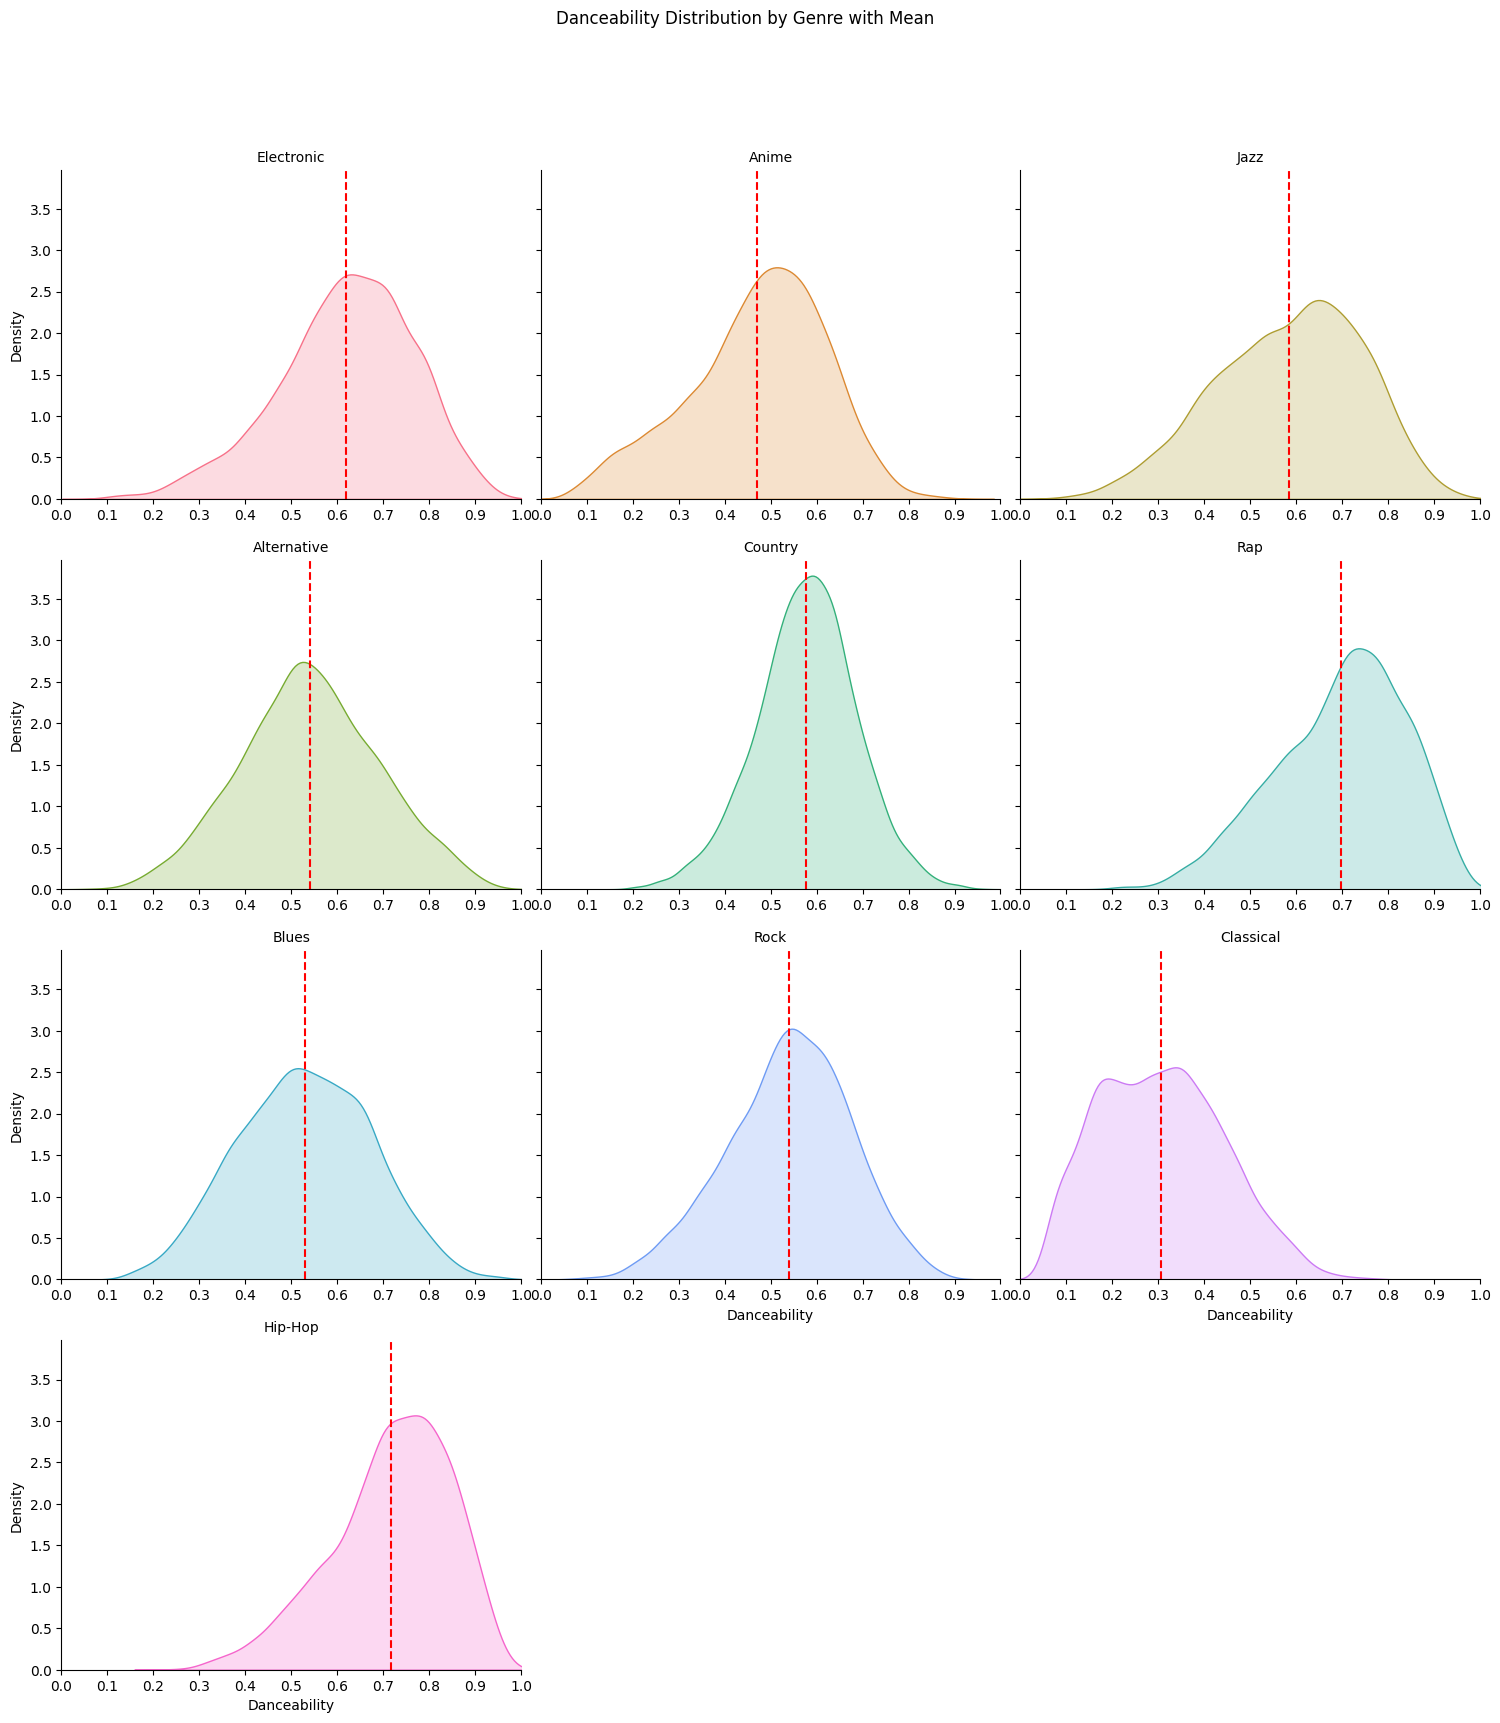

In [24]:
# Visualize the distribution of the danceability column depending on the genre
g = sns.FacetGrid(music_df, col="music_genre", col_wrap=3, height=5, sharex=False, sharey=True, hue="music_genre", palette="husl")


def add_kde_with_mean(data, **kwargs):
    sns.kdeplot(data=data, x="danceability", fill=True, **kwargs)
    plt.axvline(data["danceability"].mean(), color='red', linestyle='--', label='Mean')  

g.map_dataframe(add_kde_with_mean)

for ax in g.axes.flat:
  ax.set_xlim(0, 1)
  ax.set_xticks(np.arange(0, 1.1, 0.1))

g.set_titles("{col_name}")
g.set_axis_labels("Danceability", "Density")
plt.subplots_adjust(bottom=0.15, top=0.9) 
g.figure.suptitle('Danceability Distribution by Genre with Mean')
plt.show()

Aquí destacan el Rap y el Hip-Hop como géneros con mayor  bailabilidad. Por otra parte, la música clásica es el género con menor bailabilidad.

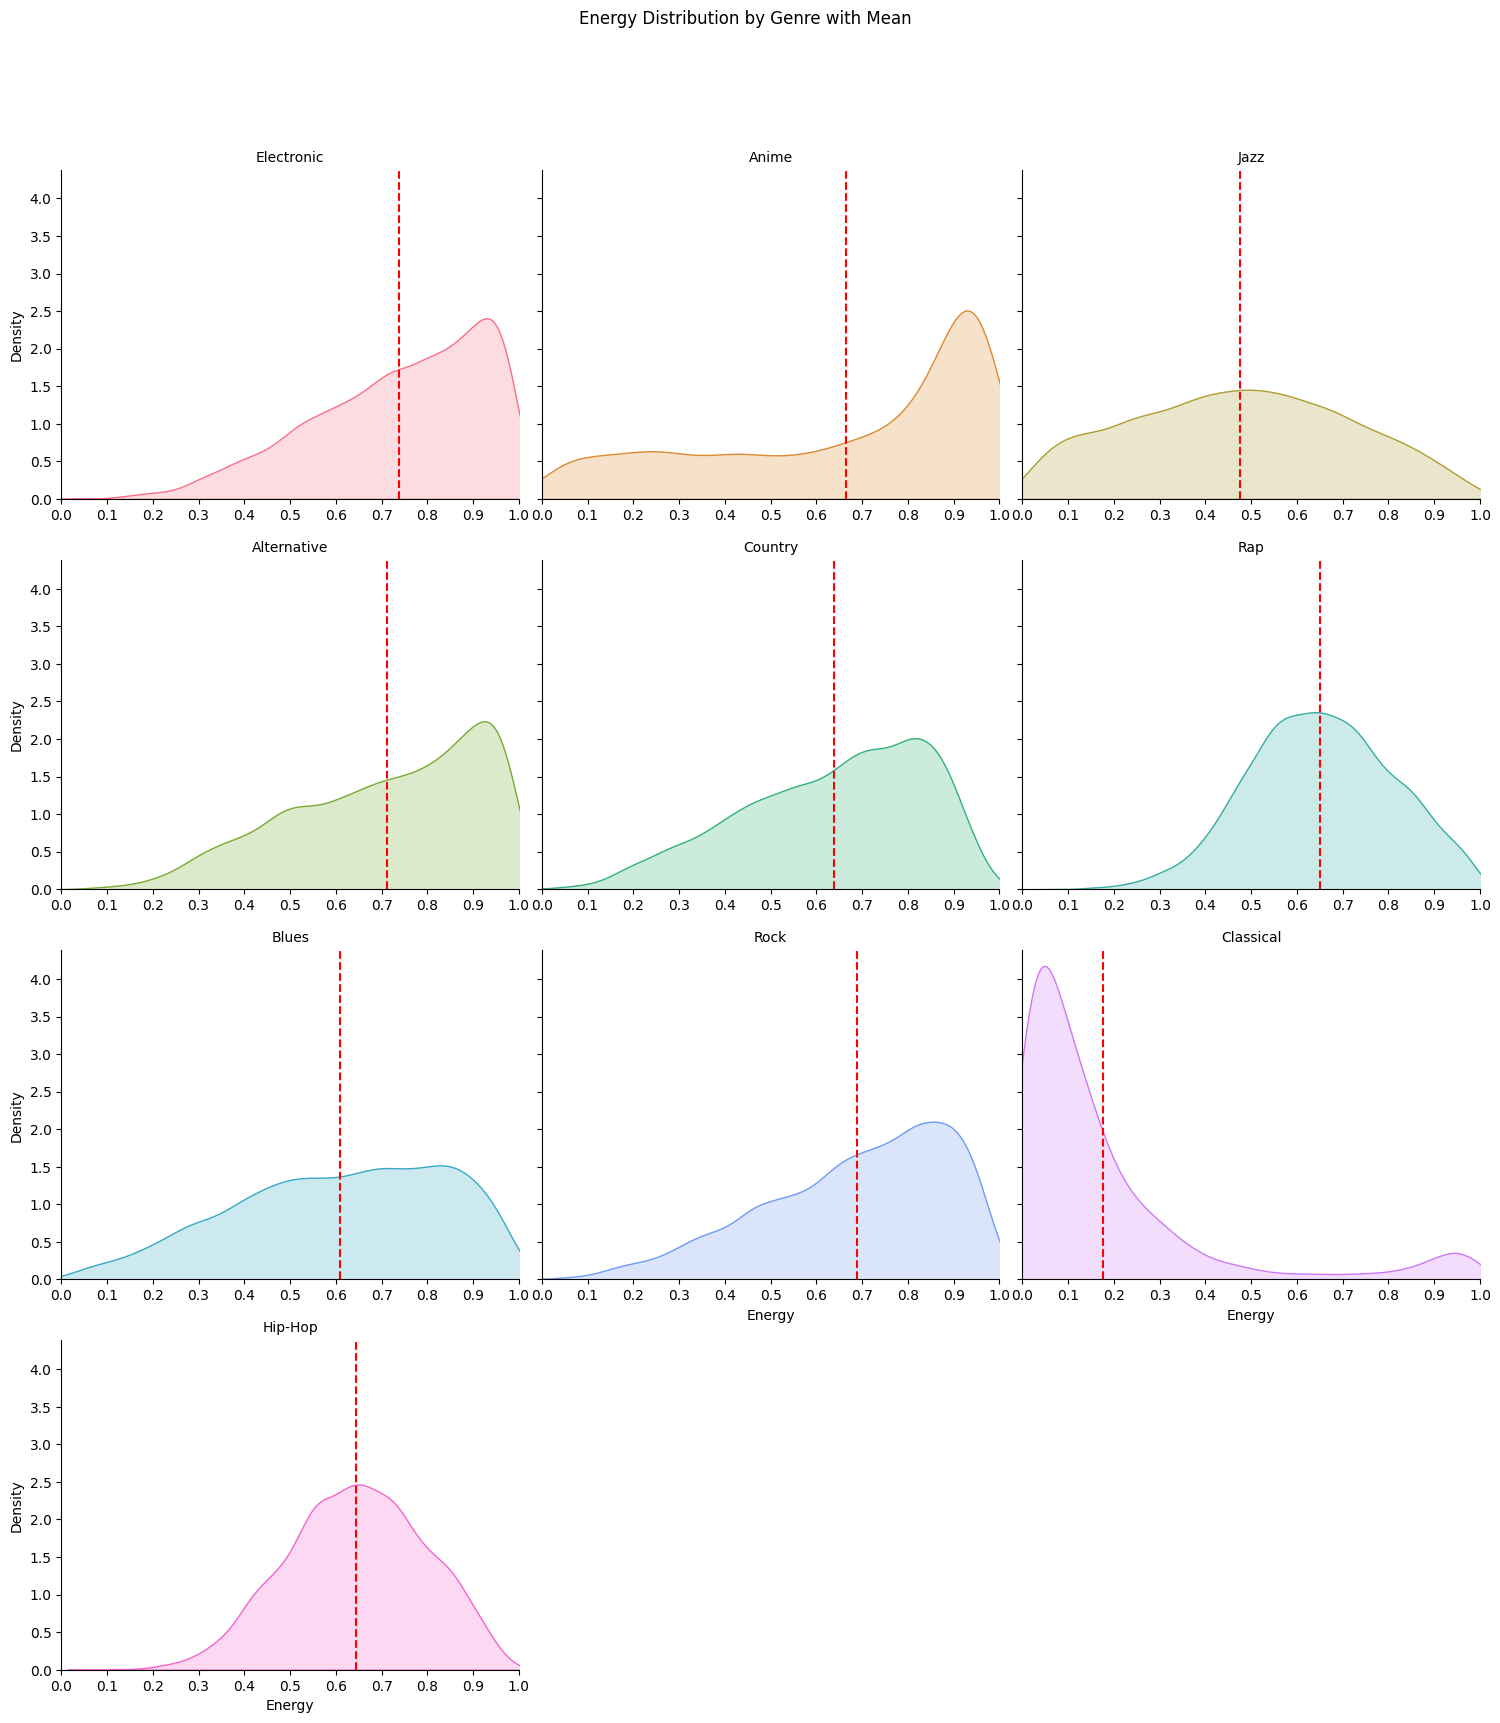

In [25]:
# Visualize the distribution of the energy column depending on the genre
g = sns.FacetGrid(music_df, col="music_genre", col_wrap=3, height=5, sharex=False, sharey=True, hue="music_genre", palette="husl")


def add_kde_with_mean(data, **kwargs):
    sns.kdeplot(data=data, x="energy", fill=True, **kwargs)
    plt.axvline(data["energy"].mean(), color='red', linestyle='--', label='Mean')  

g.map_dataframe(add_kde_with_mean)

for ax in g.axes.flat:
  ax.set_xlim(0, 1)
  ax.set_xticks(np.arange(0, 1.1, 0.1))

g.set_titles("{col_name}")
g.set_axis_labels("Energy", "Density")
plt.subplots_adjust(bottom=0.15, top=0.9) 
g.figure.suptitle('Energy Distribution by Genre with Mean')
plt.show()

En este caso la distribución es mas dispersa, pero destacamos la música clásica como género menos enérgico y con una densidad más alta cercana al 0. Otros géneros por otra parte están muy dispersos o tienen una densidad mucho más estable como el jazz o el blues.

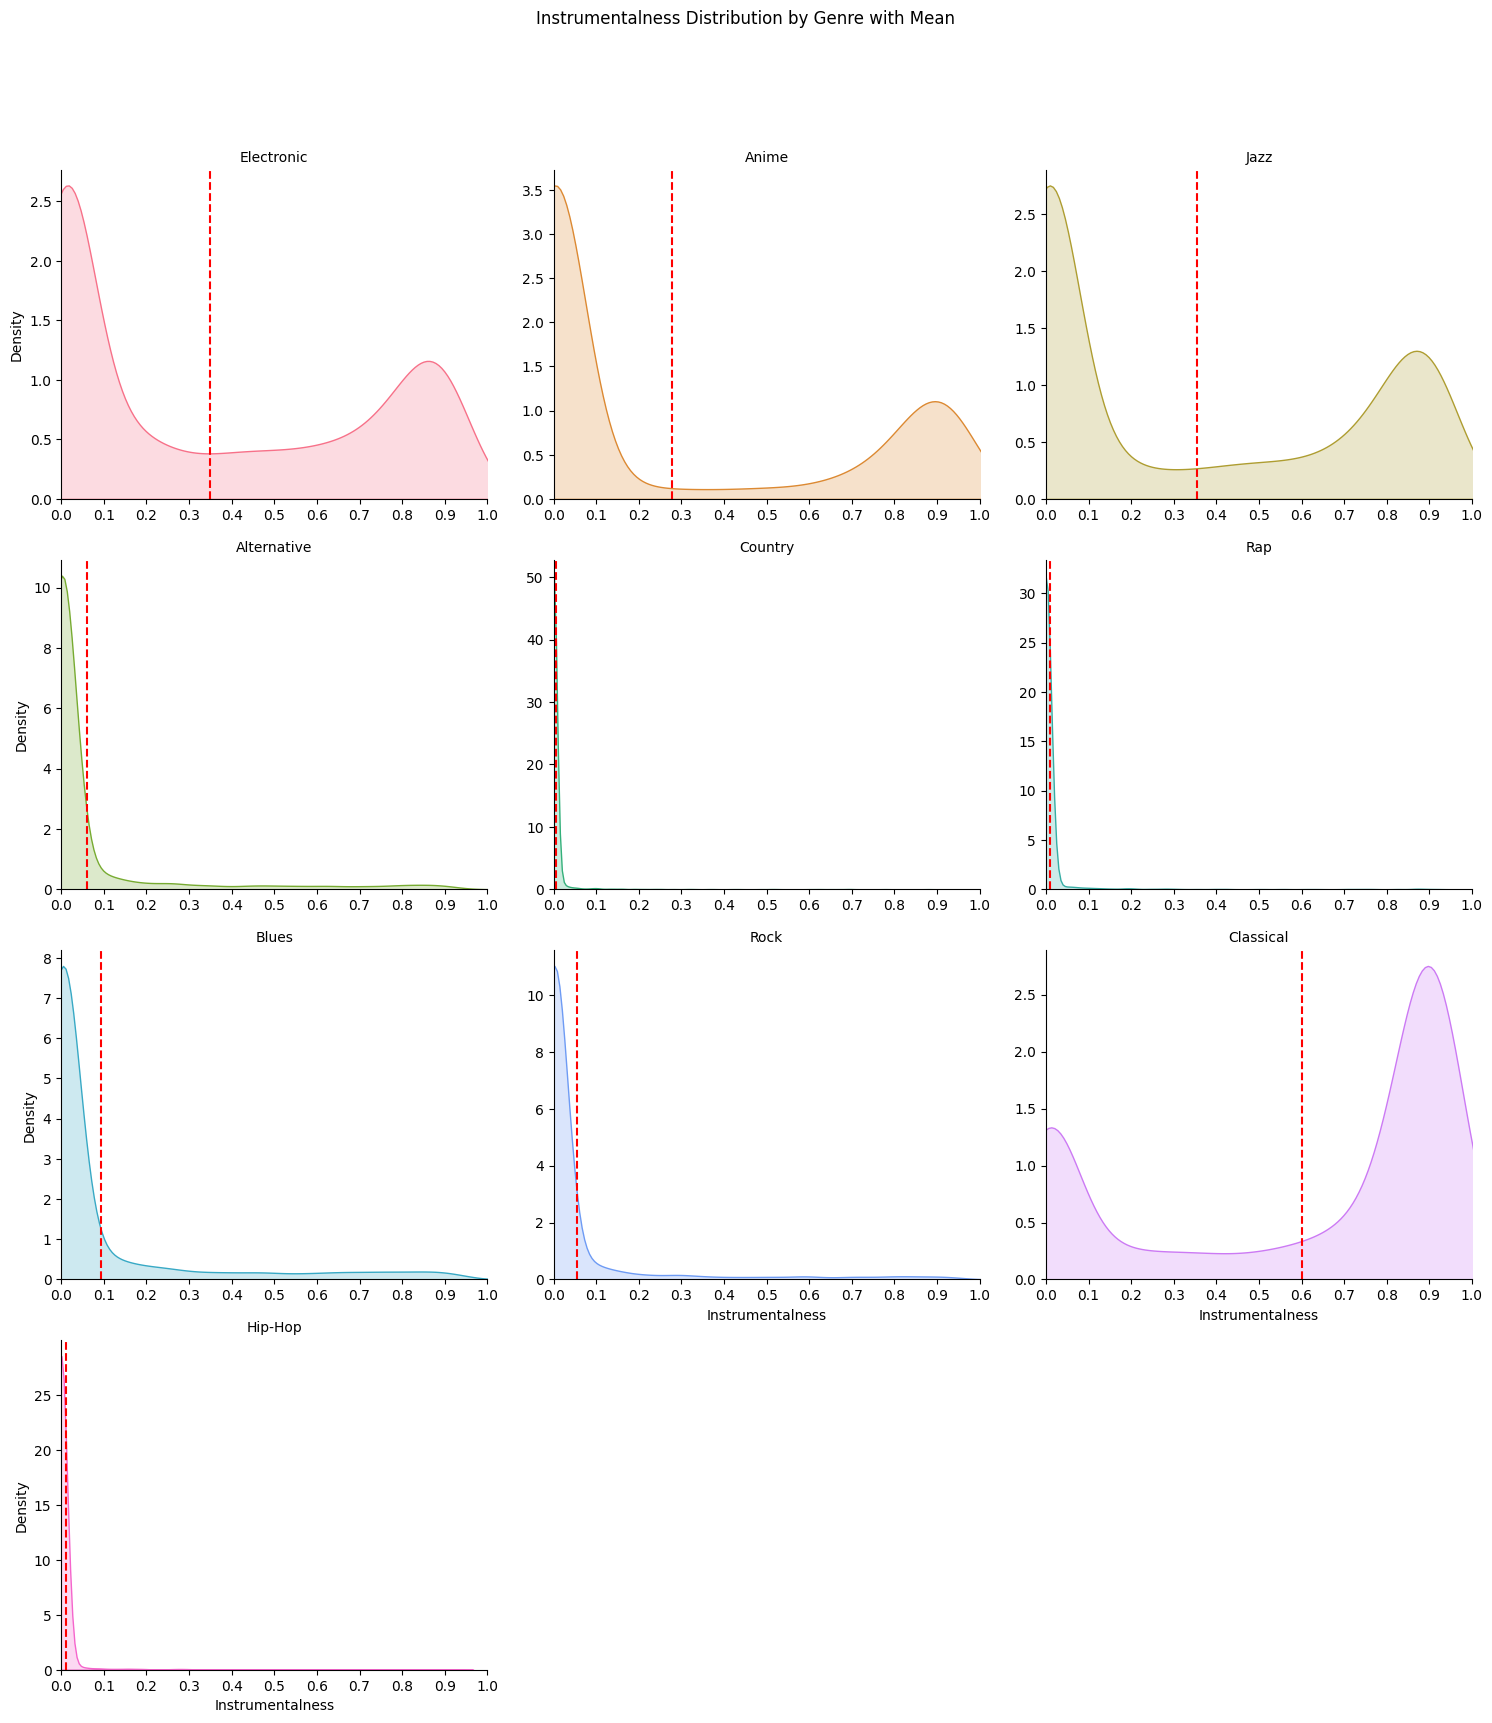

In [26]:
# Visualize the distribution of the instrumentalness column depending on the genre
g = sns.FacetGrid(music_df, col="music_genre", col_wrap=3, height=5, sharex=False, sharey=False, hue="music_genre", palette="husl")


def add_kde_with_mean(data, **kwargs):
    sns.kdeplot(data=data, x="instrumentalness", fill=True, **kwargs)
    plt.axvline(data["instrumentalness"].mean(), color='red', linestyle='--', label='Mean')  

g.map_dataframe(add_kde_with_mean)

for ax in g.axes.flat:
  ax.set_xlim(0, 1)
  ax.set_xticks(np.arange(0, 1.1, 0.1))

g.set_titles("{col_name}")
g.set_axis_labels("Instrumentalness", "Density")
plt.subplots_adjust(bottom=0.15, top=0.9) 
g.figure.suptitle('Instrumentalness Distribution by Genre with Mean')
plt.show()

Aquí hay diferencia entre los géneros cuya música es puramente instrumental (música clásica), géneros donde el factor vocal es imprescindible como el hip-hop, rap, country... y géneros que tienen un poco de ambos mundos, (como la electrónica, jazz...) aunque estos últimos con mayor densidad en el rango de música no puramente instrumental.

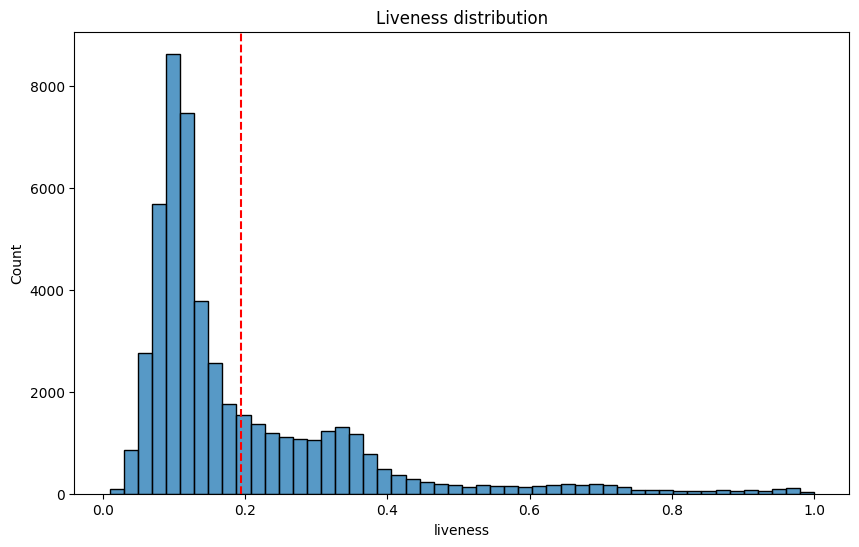

In [27]:
# Visualize the distribution of the liveness column

plt.figure(figsize=(10, 6))
sns.histplot(music_df['liveness'], bins=50)
plt.axvline(music_df['liveness'].mean(), color='red', linestyle='--', label='Mean')
plt.title('Liveness distribution')
plt.show()

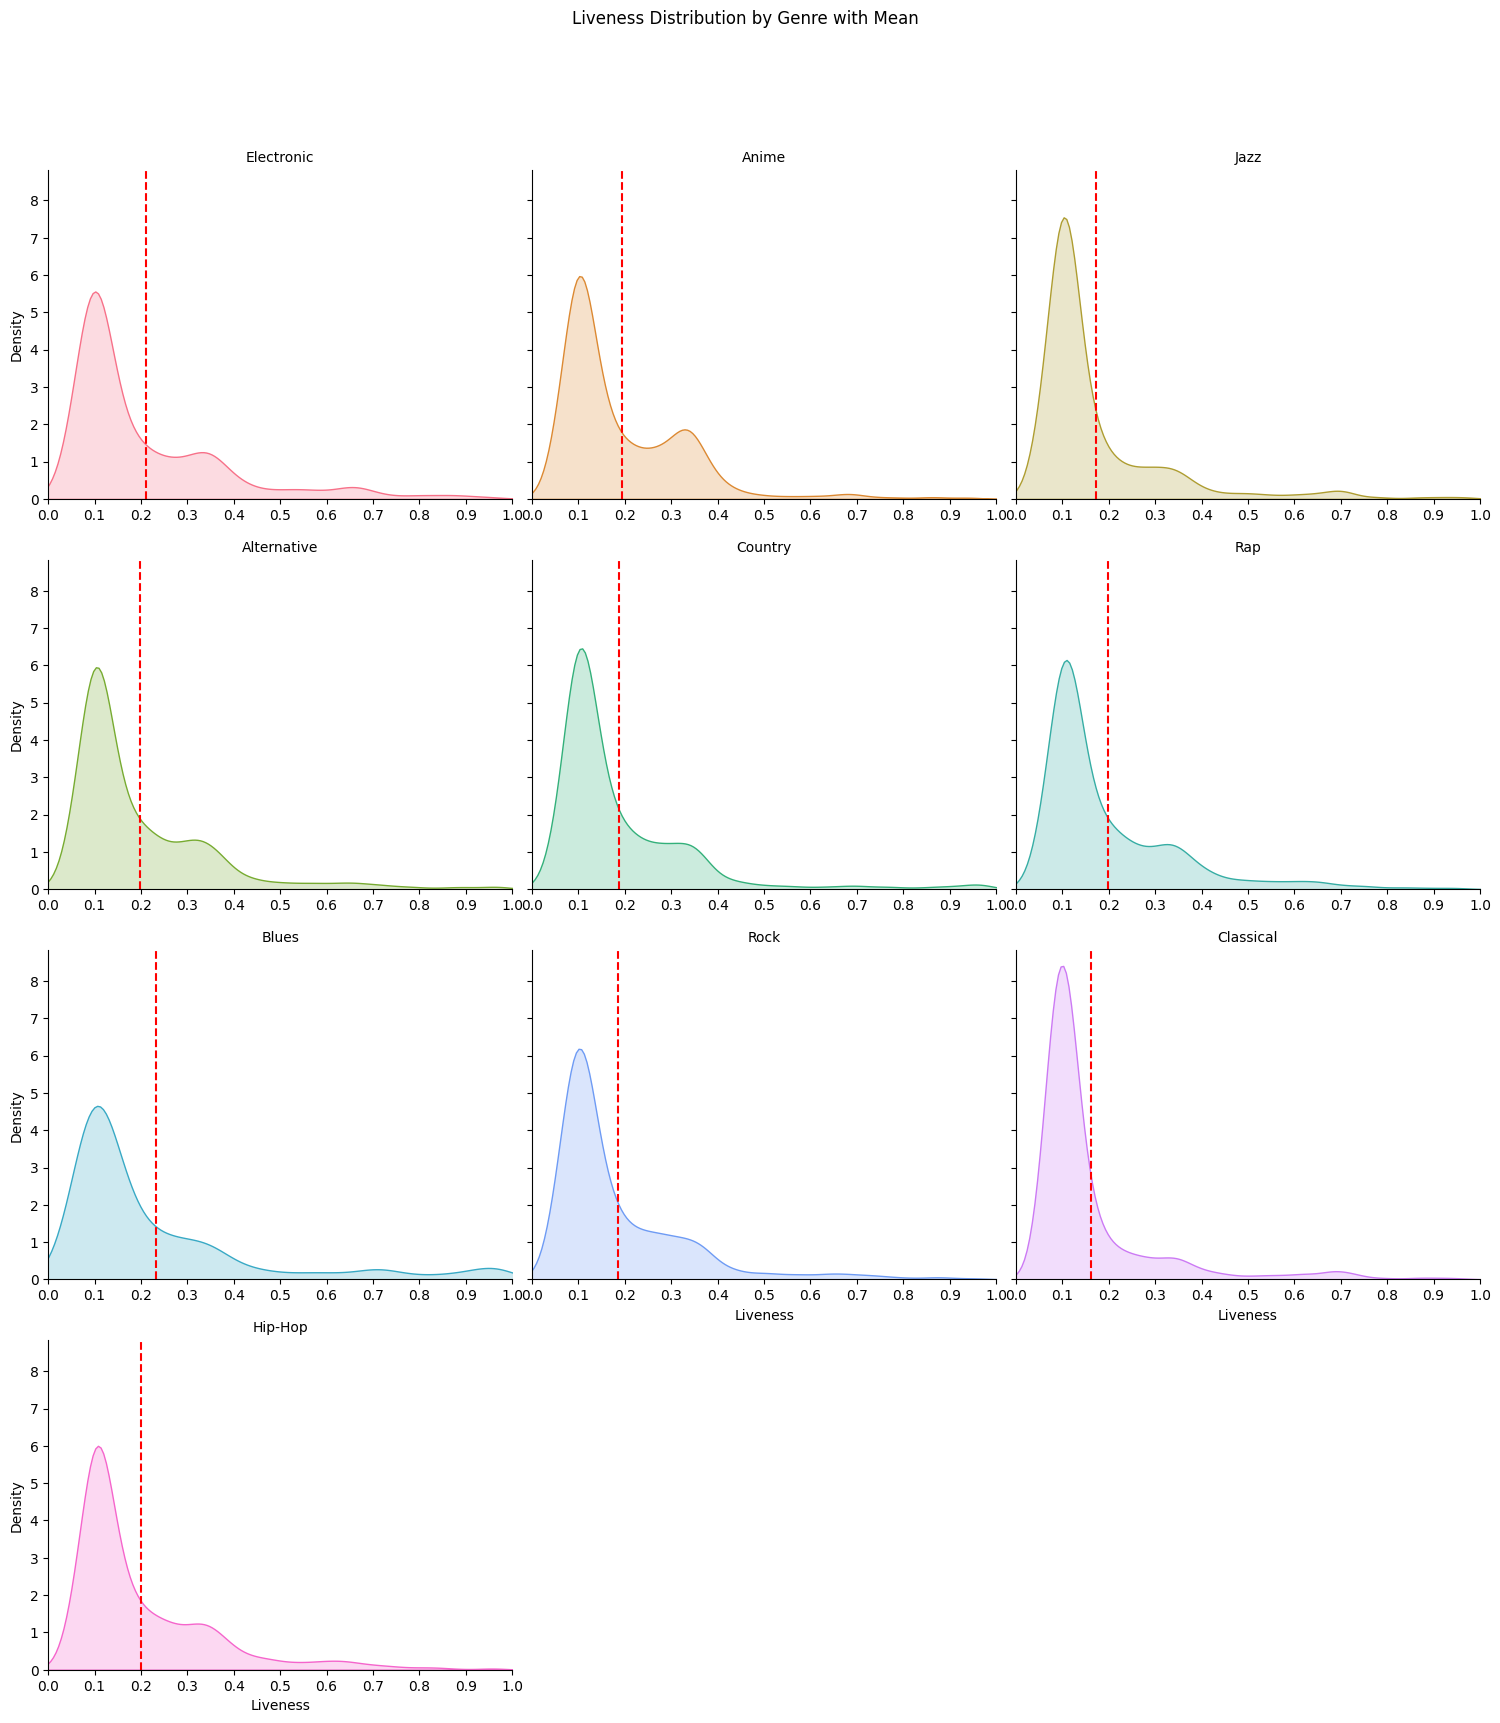

In [28]:
# Visualize the distribution of the liveness column depending on the genre
g = sns.FacetGrid(music_df, col="music_genre", col_wrap=3, height=5, sharex=False, sharey=True, hue="music_genre", palette="husl")

def add_kde_with_mean(data, **kwargs):
    sns.kdeplot(data=data, x="liveness", fill=True, **kwargs)
    plt.axvline(data["liveness"].mean(), color='red', linestyle='--', label='Mean')
  
g.map_dataframe(add_kde_with_mean)

for ax in g.axes.flat:
  ax.set_xlim(0, 1)
  ax.set_xticks(np.arange(0, 1.1, 0.1))
  
g.set_titles("{col_name}")

g.set_axis_labels("Liveness", "Density")
g.figure.suptitle('Liveness Distribution by Genre with Mean')
plt.subplots_adjust(bottom=0.15, top=0.9)

plt.show()

No hemos detectado diferencias significativas

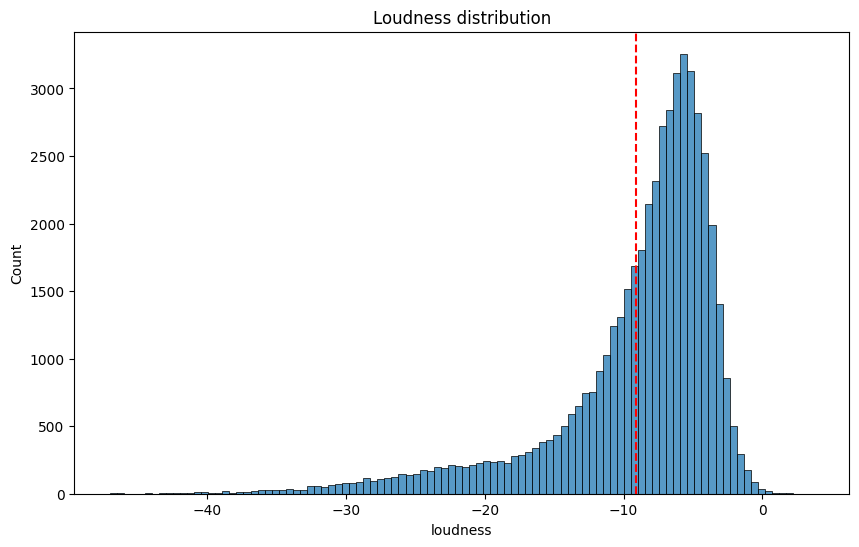

In [29]:
# Visualize the distribution of the loudness column
plt.figure(figsize=(10, 6))
sns.histplot(music_df['loudness'], bins=100)
plt.axvline(music_df['loudness'].mean(), color='red', linestyle='--', label='Mean')
plt.title('Loudness distribution')
plt.show()

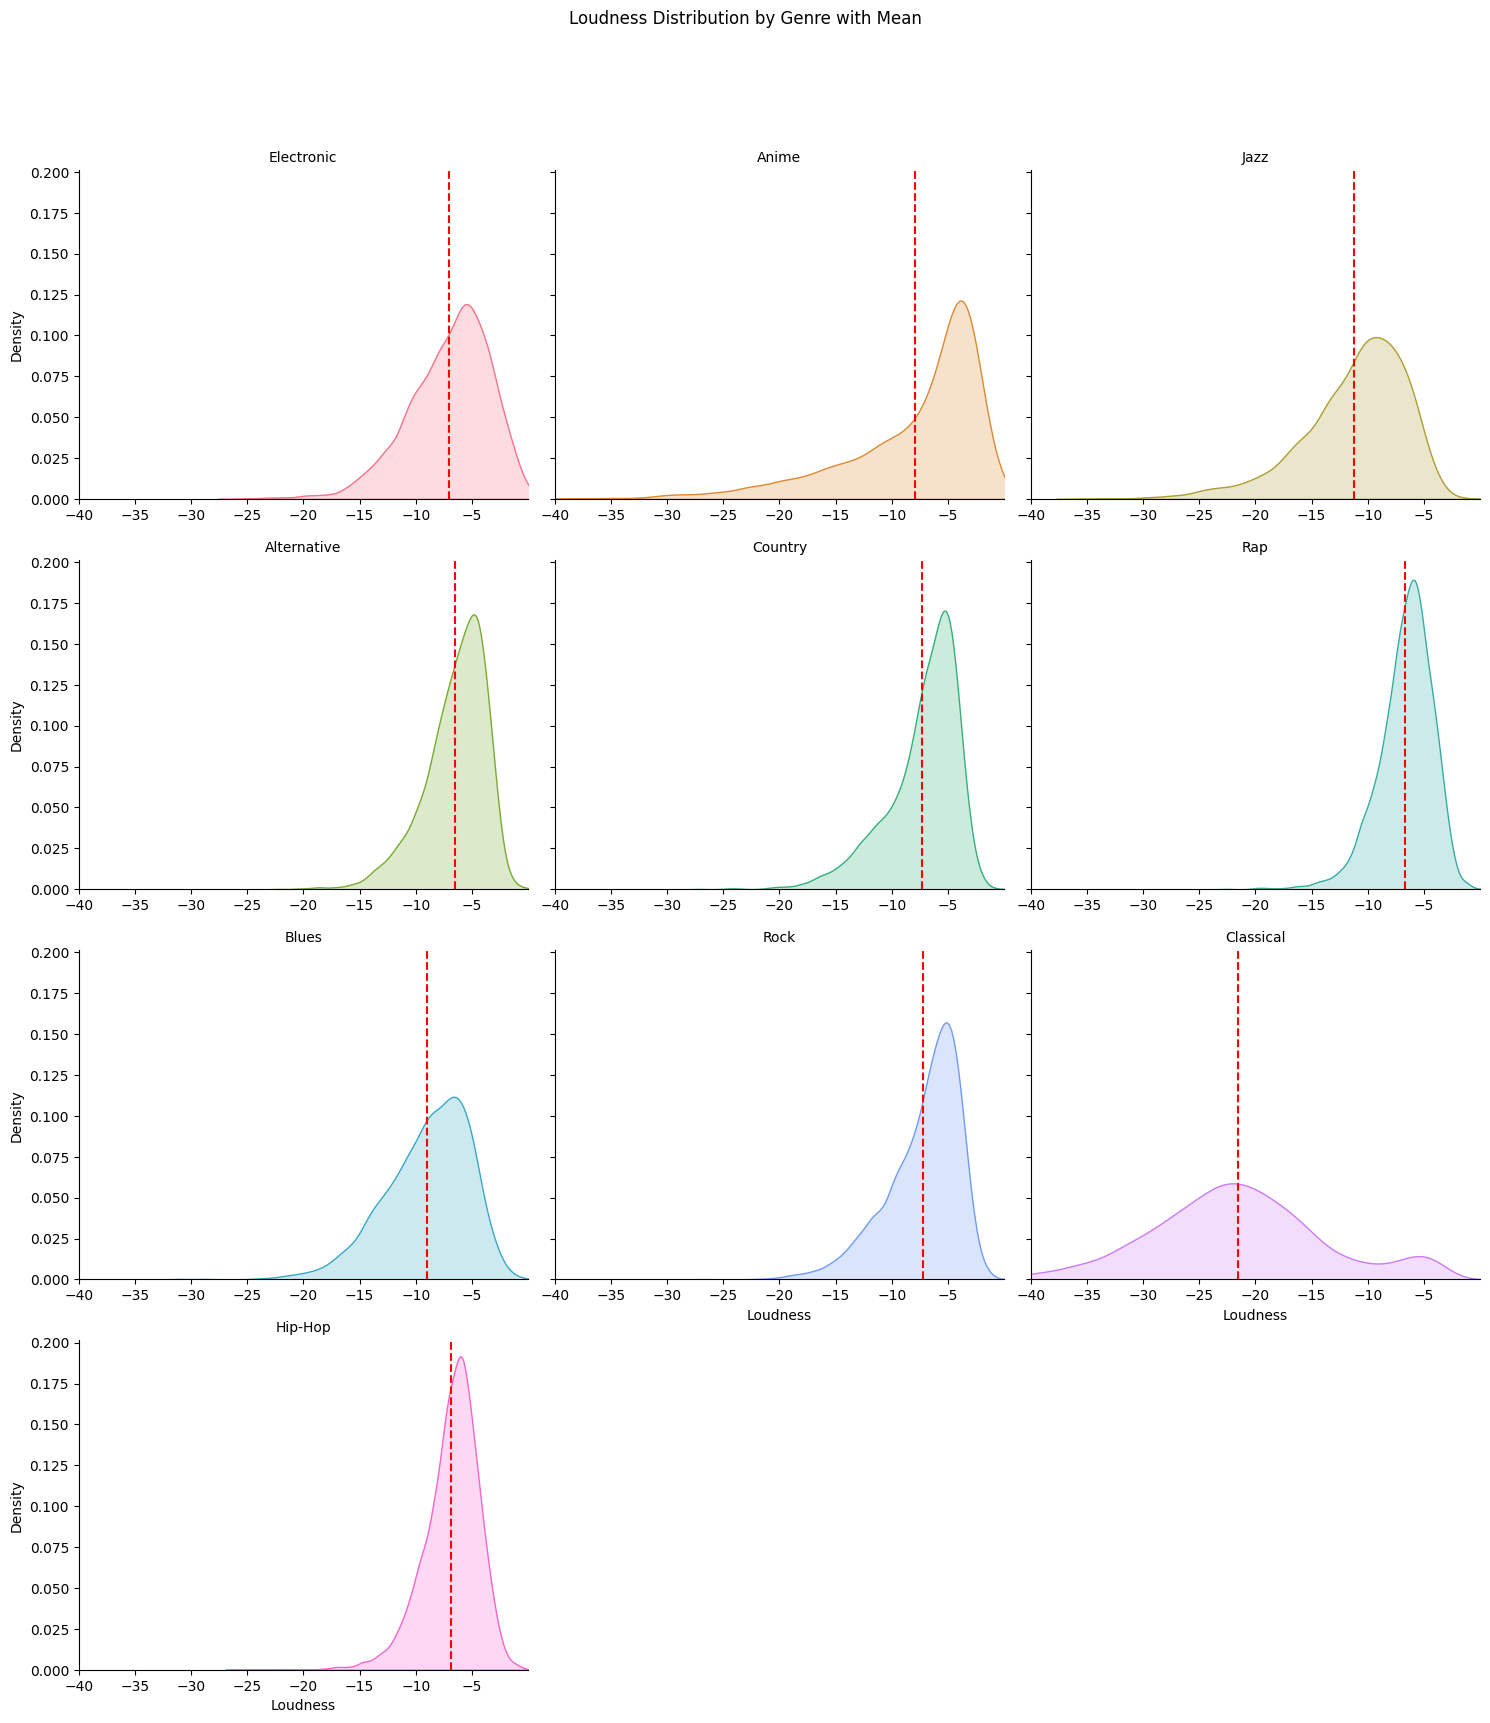

In [30]:
# Visualize the distribution of the loudness column depending on the genre
g = sns.FacetGrid(music_df, col="music_genre", col_wrap=3, height=5, sharex=False, sharey=True, hue="music_genre", palette="husl")

def add_kde_with_mean(data, **kwargs):
    sns.kdeplot(data=data, x="loudness", fill=True, **kwargs)
    plt.axvline(data["loudness"].mean(), color='red', linestyle='--', label='Mean')
    
g.map_dataframe(add_kde_with_mean)

for ax in g.axes.flat:
  ax.set_xlim(-40, 0)
  ax.set_xticks(range(-40, 0, 5))
  
g.set_titles("{col_name}")
g.set_axis_labels("Loudness", "Density")

g.figure.suptitle('Loudness Distribution by Genre with Mean')
plt.subplots_adjust(bottom=0.15, top=0.9)

plt.show()

Aquí se destaca la música clásica con mayor dispersión en el volumen de la mezcla. Esto se debe a que la música clásica aprovecha mucho el rango dinámico.

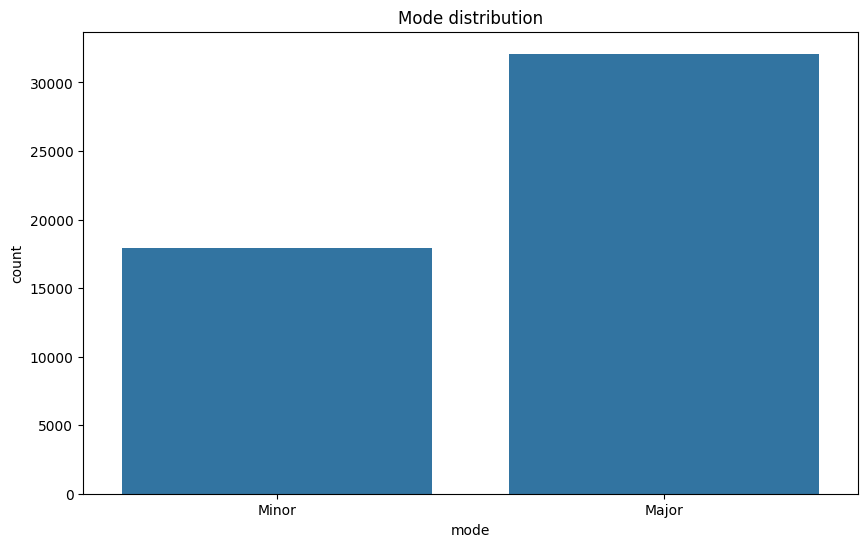

In [31]:
# Visualize the modes distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='mode', data=music_df)
plt.title('Mode distribution')
plt.show()

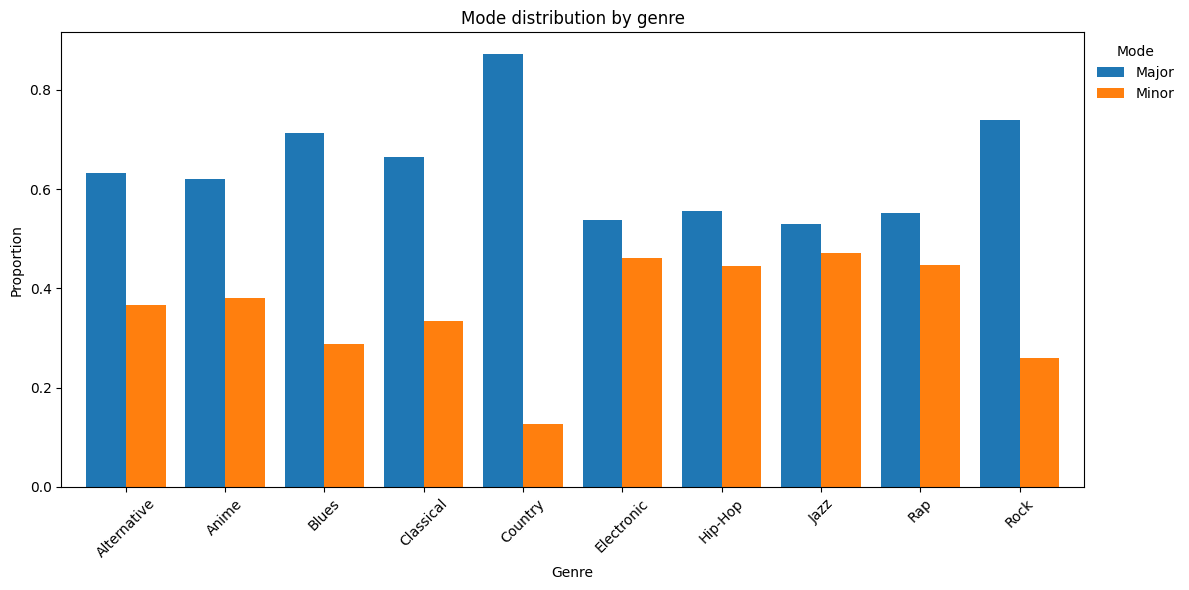

In [32]:
# Reformatear los datos para obtener un par de barras para cada género
mode_genre_distribution = music_df.groupby('music_genre')['mode'].value_counts(normalize=True).unstack()

# Crear el gráfico
mode_genre_distribution.plot(kind='bar', figsize=(12, 6), width=0.8)

# Personalizar el gráfico
plt.legend(title='Mode', bbox_to_anchor=(1, 1), loc='upper left', frameon=False)
plt.title('Mode distribution by genre')
plt.xlabel('Genre')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Hay géneros que apenas usan la escala menor como el country, y otros géneros que están mucho más parejos como la electrónica, hip-hop, jazz, rap.

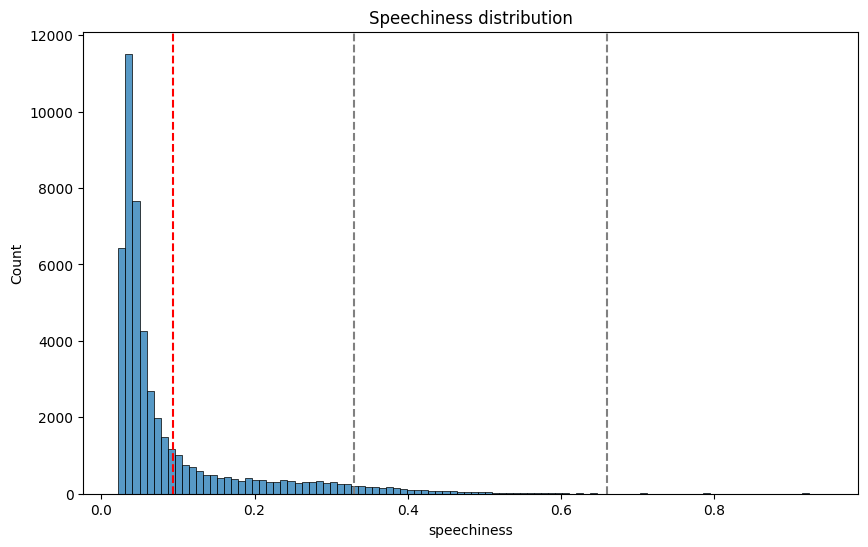

In [33]:
# Visualize the distribution of the speechiness column
plt.figure(figsize=(10, 6))
sns.histplot(music_df['speechiness'], bins=100)
plt.axvline(music_df['speechiness'].mean(), color='red', linestyle='--', label='Mean')
plt.axvline(0.33, color='grey', linestyle='--', label='.33')
plt.axvline(0.66, color='grey', linestyle='--', label='.66')
plt.title('Speechiness distribution')
plt.show()

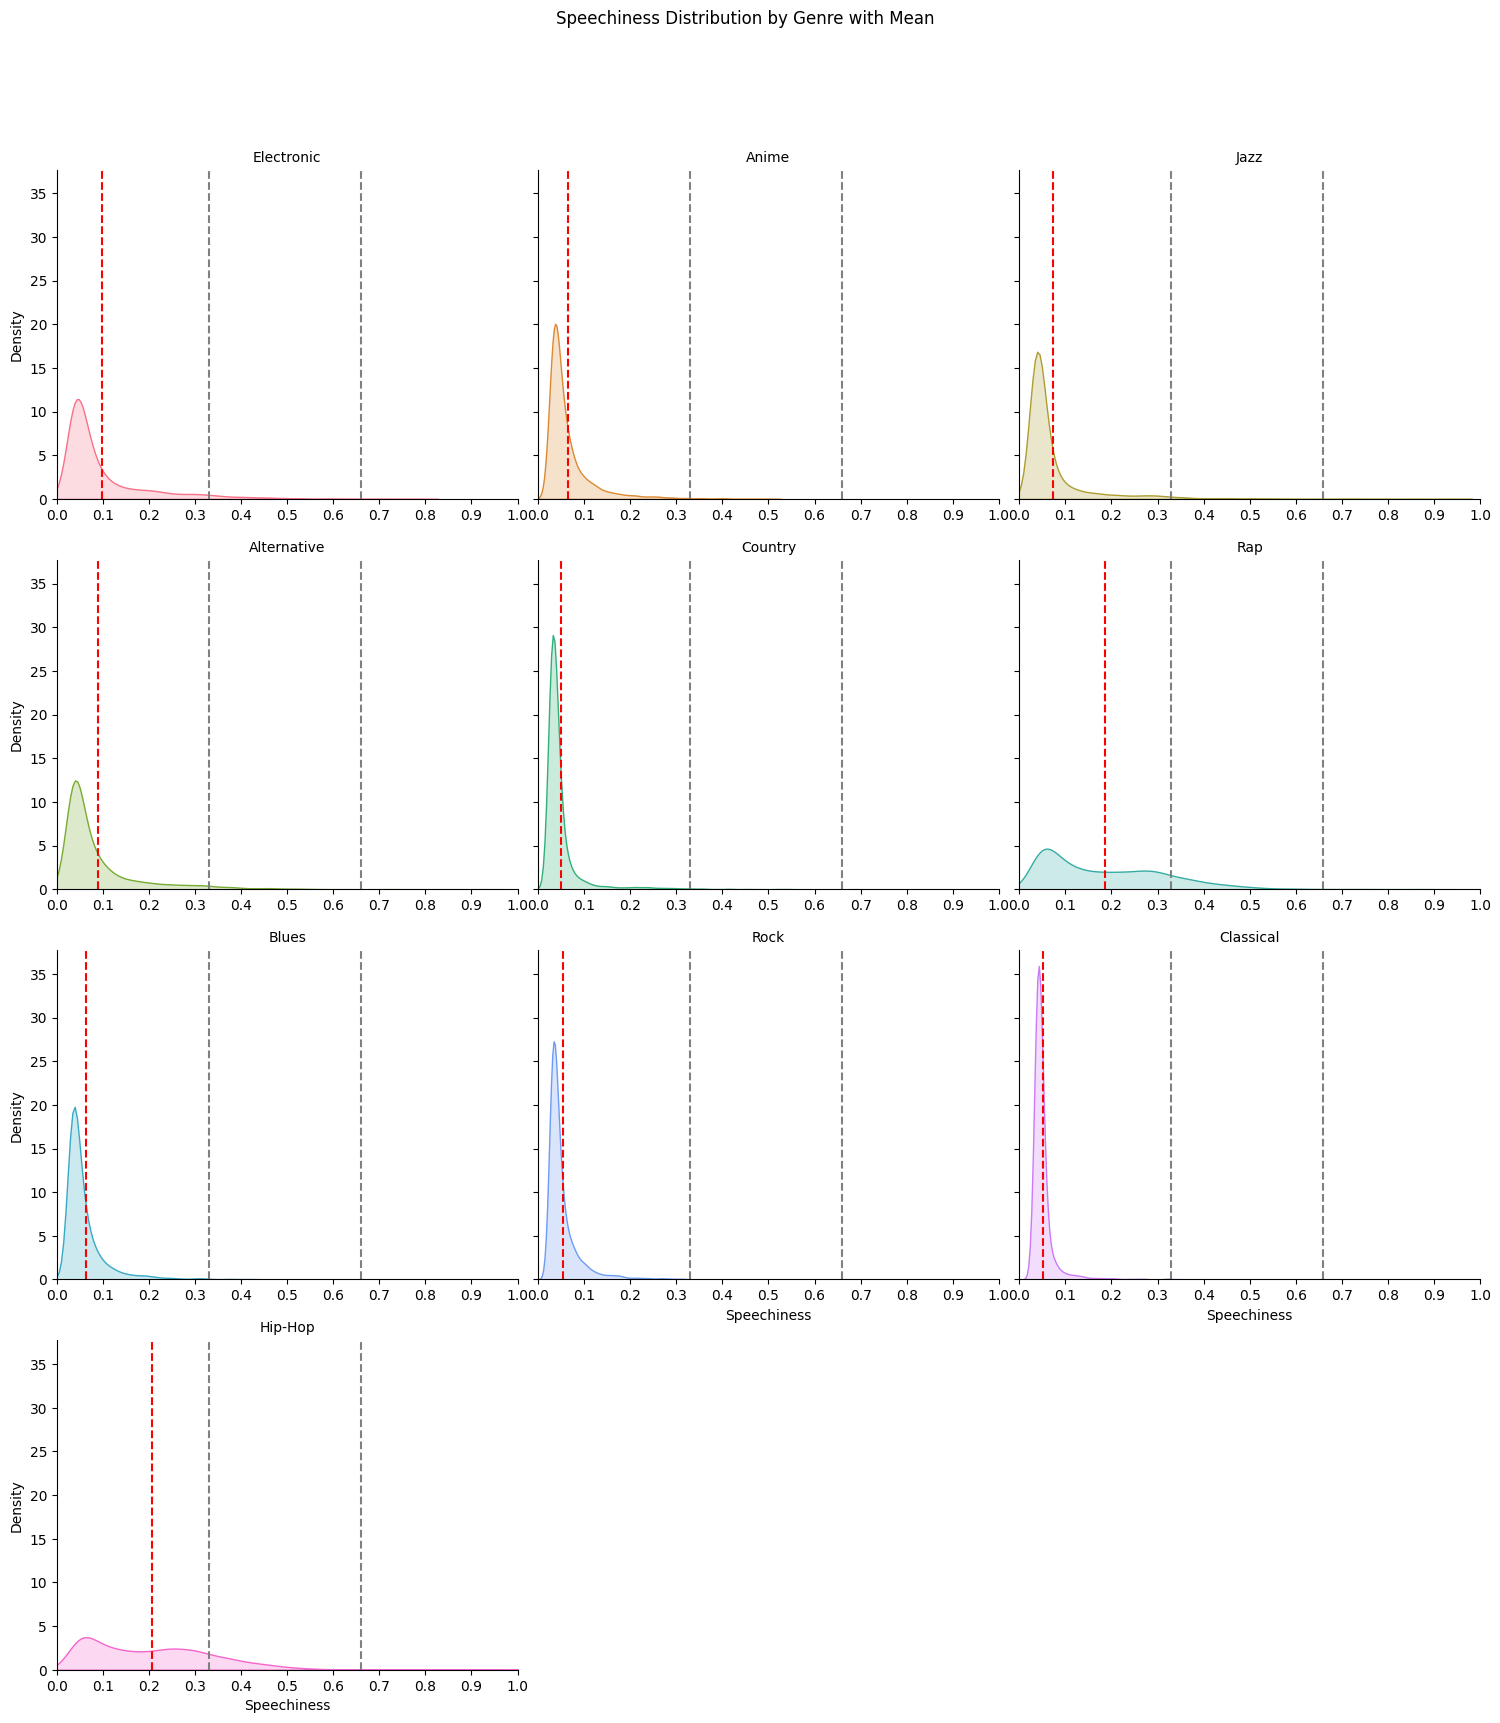

In [34]:
# Visualize the distribution of the speechiness column depending on the genre
g = sns.FacetGrid(music_df, col="music_genre", col_wrap=3, height=5, sharex=False, sharey=True, hue="music_genre", palette="husl")

def add_kde_with_mean(data, **kwargs):
    sns.kdeplot(data=data, x="speechiness", fill=True, **kwargs)
    plt.axvline(data["speechiness"].mean(), color='red', linestyle='--', label='Mean')
    plt.axvline(0.33, color='grey', linestyle='--', label='.33')
    plt.axvline(0.66, color='grey', linestyle='--', label='.66')
    
g.map_dataframe(add_kde_with_mean)

for ax in g.axes.flat:
  ax.set_xlim(0, 1)
  ax.set_xticks(np.arange(0, 1.1, 0.1))
  
g.set_titles("{col_name}")
g.set_axis_labels("Speechiness", "Density")
g.figure.suptitle('Speechiness Distribution by Genre with Mean')
plt.subplots_adjust(bottom=0.15, top=0.9)

plt.show()

Hay géneros donde el diálogo (pueden ser rimas con ritmo) es más prominente que la propia voz entonada, por ello el hip-hop y el rap tienen densidades más dispersas entre el 0 y el 0.5.

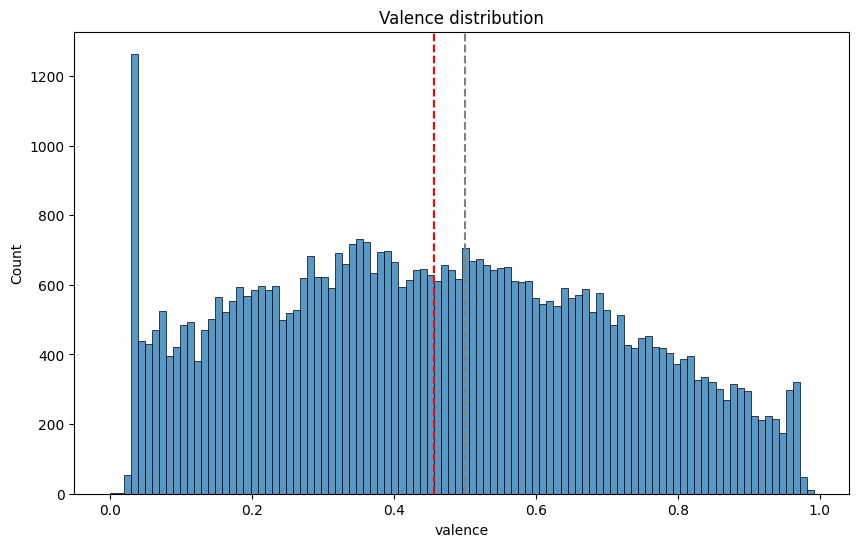

In [35]:
# Visualize the distribution of the valence column
plt.figure(figsize=(10, 6))
sns.histplot(music_df['valence'], bins=100)
plt.axvline(music_df['valence'].mean(), color='red', linestyle='--', label='Mean')
plt.axvline(0.5, color='grey', linestyle='--', label='.33')
plt.title('Valence distribution')
plt.show()

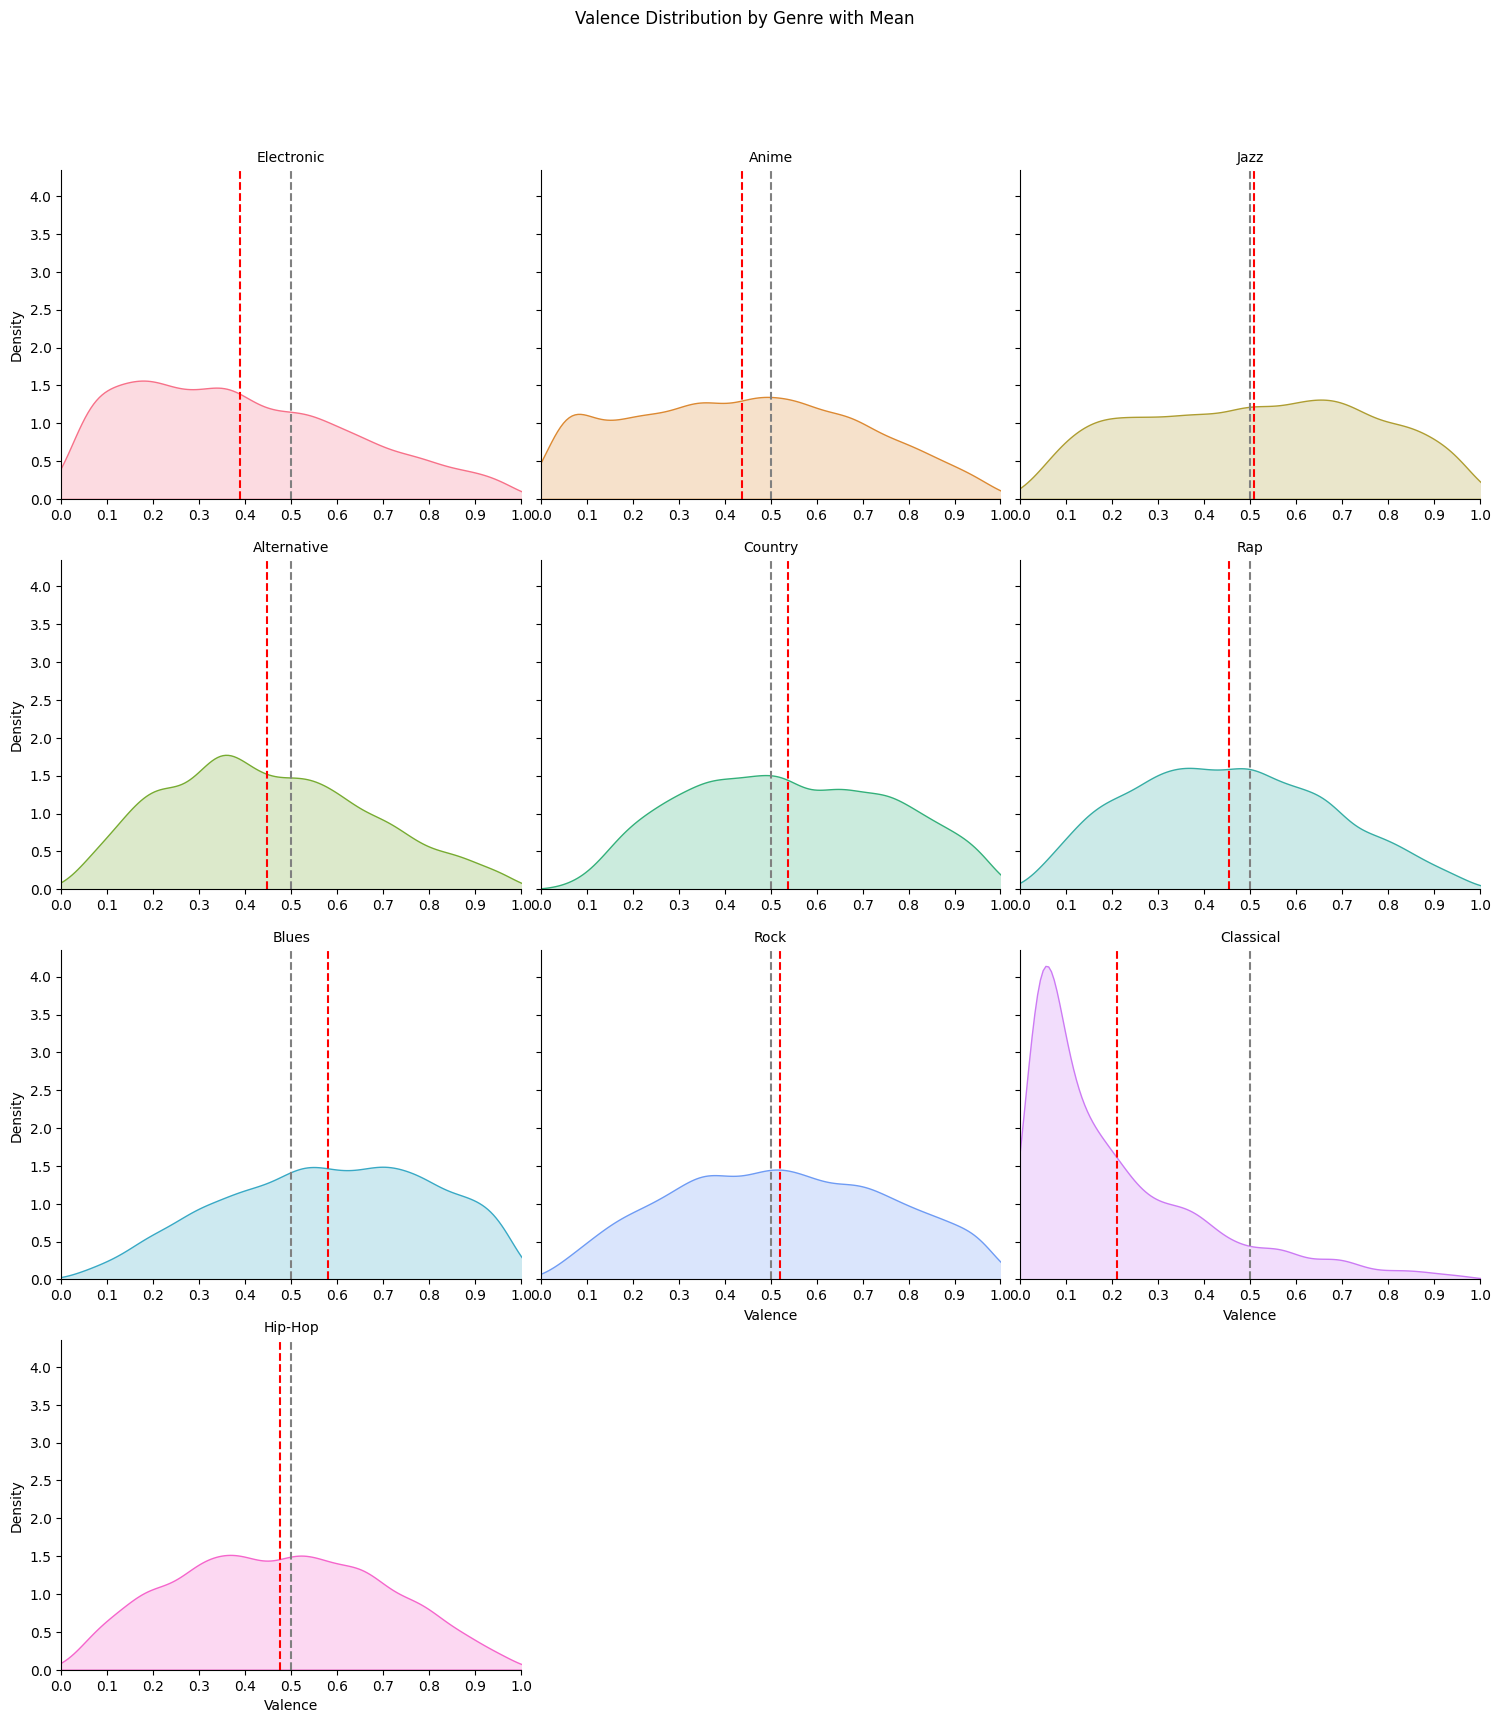

In [36]:
# Visualize the distribution of the valence column depending on the genre
g = sns.FacetGrid(music_df, col="music_genre", col_wrap=3, height=5, sharex=False, sharey=True, hue="music_genre", palette="husl")

def add_kde_with_mean(data, **kwargs):
    sns.kdeplot(data=data, x="valence", fill=True, **kwargs)
    plt.axvline(data["valence"].mean(), color='red', linestyle='--', label='Mean')
    plt.axvline(0.5, color='grey', linestyle='--', label='.33')

g.map_dataframe(add_kde_with_mean)

for ax in g.axes.flat:
  ax.set_xlim(0, 1)
  ax.set_xticks(np.arange(0, 1.1, 0.1))
  
g.set_titles("{col_name}")
g.set_axis_labels("Valence", "Density")
g.figure.suptitle('Valence Distribution by Genre with Mean')
plt.subplots_adjust(bottom=0.15, top=0.9)

plt.show()

En este caso destaca la música clásica como género cuya mayor densidad de música está en la parte de valencia baja, es decir, la música clásica evoca más bien emociones negativas.

### 4. Tratamiento de duplicados

En este punto investigaremos sobre los duplicados en el dataset. Trataremos como duplicados aquellas canciones cuyo nombre de artista y nombre de la canción sean idénticos. En un principio realizamos esto en caso de que existieran varios lanzamientos de una misma canción, con el fin de quedarnos con la información de únicamente una de ellas, ya que realmente no nos interesaba tener información pseudorepetida. Para estudiar esto procedimos a guardar los duplicados en un csv.

In [37]:
# Are there duplicate songs in the dataset?
duplicates = music_df[music_df.duplicated(subset=['track_name', 'artist_name'], keep=False)].sort_values('track_name')
duplicates.to_csv('duplicate_song.csv', index=False)

Nuestra sorpresa fue que gran parte de las canciones estaban repetidas, y no solo debido a la existencia de distintos lanzamientos (como versiones deluxe, remasterizadas o en vivo), sino también por cómo está diseñado Spotify y el dataset en uso, ya que una canción puede estar etiquetada con varios géneros y en nuestro caso, esto se refleja en la repetición de canciones con una etiqueta distinta.

Para saber cómo resolver este problema decidimos comenzar visualizando la distribución de las canciones repetidas  según el género, con la esperanza de que la mayoría estuviesen asociadas a un mismo género y poder eliminarlo como solución inmediata.

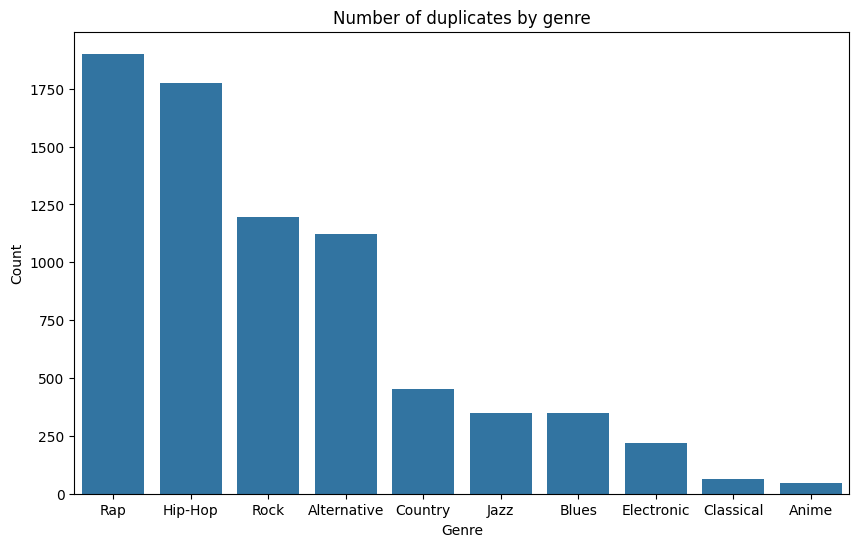

In [38]:
# Visualize number of duplicates by genre
duplicates_songs_genre_count = duplicates['music_genre'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=duplicates_songs_genre_count.index, y=duplicates_songs_genre_count.values)
plt.title('Number of duplicates by genre')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()

El resultado no es el deseado ya que la distribución es bastante ámplia y los géneros bastante significativos. Entonces decidimos hacer un estudio de "subgéneros". Para ello cogeremos cada canción, sacaremos todos sus géneros (de las filas que tienen mismo nombre de artista y de canción) e iremos contando cuantas canciones hay de cada subgénero.

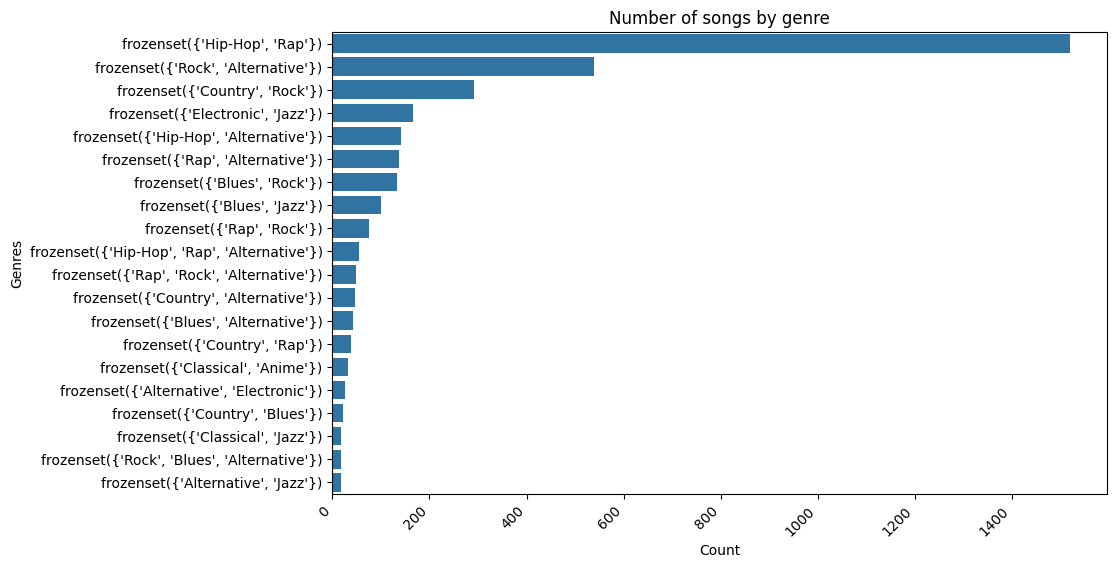

In [39]:
grouped_duplicate_songs = duplicates.groupby(['track_name', 'artist_name'])

grouped_duplicate_songs_by_genres = {}
duplicate_songs_by_genres = {}
for name, group in grouped_duplicate_songs:
  genre_set = frozenset(group['music_genre'])
  if genre_set not in grouped_duplicate_songs_by_genres:
    grouped_duplicate_songs_by_genres[genre_set] = group
    duplicate_songs_by_genres[genre_set] = 1
  else:
    grouped_duplicate_songs_by_genres[genre_set] = pd.concat([grouped_duplicate_songs_by_genres[genre_set], group])
    duplicate_songs_by_genres[genre_set] += 1

# Visualize number of songs by genre
duplicate_songs_by_genres = pd.Series(duplicate_songs_by_genres).sort_values(ascending=False)
top_20_genre_set = duplicate_songs_by_genres.head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_20_genre_set.values, y=top_20_genre_set.index)
plt.title('Number of songs by genre')
plt.xlabel('Count')
plt.ylabel('Genres')
plt.xticks(rotation=45, ha='right')
plt.show()

Hemos mostrado únicamente los 20 subgéneros más representativos. Viendo esta gráfica concluimos en que tenemos 3 opciones: Eliminar todas las canciones repetidas, quedarnos con una única canción prevaleciendo un género sobre los demás o crear nuevas etiquetas para los subgéneros. Tras discutirlo, decidimos que para experimentar un preprocesamiento más avanzado y a su vez dar una solución mucho más veraz tomaríamos la última opción, creando nuevos subgéneros para los 9 más poblados. Los siguientes subgéneros tendrían una tasa de representación tan baja que descompensarían demasiado el dataset.

In [40]:
# We will add tags for the 9 first set of genres manually
new_tags = {
  frozenset(['Rap', 'Hip-Hop']): "Hip-Hop/Rap",
  frozenset(['Alternative', 'Rock']): "Alternative Rock",
  frozenset(['Country', 'Rock']): "Country Rock",
  frozenset(['Jazz', 'Electronic']): "Electronic Jazz",
  frozenset(['Alternative', 'Hip-Hop']): "Alternative Hip-Hop",
  frozenset(['Alternative', 'Rap']): "Alternative Rap",
  frozenset(['Blues', 'Rock']): "Blues Rock",
  frozenset(['Blues', 'Jazz']): "Jazz Blues",
  frozenset(['Rap', 'Rock']): "Rap Rock"
}

Además nos percatamos de que de una misma canción había instancias donde no se tenía toda la información (de las columnas de duración y tempo). Para poder quedarnos con la mayor información posible y dado que se entiende que la información entre canciones repetidas va a tener muy alta similaridad (si no equivalencia) y que los datos de las columnas faltantes, son datos objetivos y que deberían ser equivalentes definimos un algoritmo que hace lo siguiente:

- De las canciones repetidas, toma la primera indiscriminadamente
- Se iteran sobre las columnas
- Se verifica si la columna de la canción seleccionada es nula, es decir, no tiene valor
- Si es así se asigna cualquier otro valor de entre las siguientes filas cuando sea posible

In [41]:
def merge_duplicate_songs_info(df: pd.DataFrame) -> pd.Series:
    """
    Merge the information of duplicate songs.
    If a value is missing, it will be replaced with a value from a duplicate.
    Returns a single row (pd.Series) with merged information.
    """
    # Copy the first row as the base result
    result = df.iloc[0].copy()

    # Iterate only through columns after the 3rd
    for column in df.columns[3:]:
        if pd.isna(result[column]):
            # Find the first non-null value in the column across the remaining rows
            result[column] = df[column].dropna().iloc[0] if not df[column].dropna().empty else None

    return result

Y una vez tenemos esta función podemos mergear la información y asignar la nueva etiqueta en función del subgénero, creando un nuevo dataframe y csv con datos de canciones únicas.

In [42]:
# Remove exact duplicates
unique_music_df = music_df.drop_duplicates(subset=['track_name', 'artist_name'], keep=False)

# Temporary list to store merged songs
merged_songs = []

# Iterate over groups of duplicate songs
for name, group in grouped_duplicate_songs:
    genre_set = frozenset(group['music_genre'])
    if genre_set in new_tags:
        merged_song = merge_duplicate_songs_info(group)
        merged_song['music_genre'] = new_tags[genre_set]
        merged_songs.append(merged_song)

# Create a DataFrame from the list of merged songs
merged_songs_df = pd.DataFrame(merged_songs)

# Concatenate the unique songs with the merged songs
unique_music_df = pd.concat([unique_music_df, merged_songs_df], ignore_index=True)

# Save the resulting DataFrame to a CSV file
unique_music_df.to_csv('unique_music_genre.csv', index=False)

Para asegurarnos de que todo está en orden

In [43]:
# Check if there are any duplicates now
print(f"Number of duplicates: {unique_music_df.duplicated(subset=['track_name', 'artist_name'], keep=False).sum()}")


Number of duplicates: 0


¿Con cuántos datos nos hemos quedado tras la operación?

In [44]:
# Check the new shape of the dataset
print(unique_music_df.shape)

(45635, 17)


¿Cuántos géneros hay ahora?

In [45]:
# Check the number of genres and which ones are present
print(unique_music_df['music_genre'].nunique())
print(unique_music_df['music_genre'].unique())

19
['Electronic' 'Anime' 'Jazz' 'Alternative' 'Country' 'Rap' 'Blues' 'Rock'
 'Classical' 'Hip-Hop' 'Electronic Jazz' 'Alternative Rock' 'Blues Rock'
 'Alternative Hip-Hop' 'Hip-Hop/Rap' 'Country Rock' 'Alternative Rap'
 'Rap Rock' 'Jazz Blues']


¿Cuántas instancias hay para cada género?

In [46]:
# Check number of songs by genre
songs_by_genre = unique_music_df['music_genre'].value_counts()
print(songs_by_genre)

music_genre
Anime                  4954
Classical              4936
Electronic             4783
Blues                  4651
Jazz                   4650
Country                4547
Alternative            3878
Rock                   3804
Hip-Hop                3225
Rap                    3099
Hip-Hop/Rap            1521
Alternative Rock        540
Country Rock            291
Electronic Jazz         167
Alternative Hip-Hop     142
Alternative Rap         137
Blues Rock              134
Jazz Blues              101
Rap Rock                 75
Name: count, dtype: int64


### 5. Tratamiento de nulos

En este apartado se realiza el tratamiento para los valores nulos. La opción que finalmente se llevará a cabo es la de generar información a partir de los valores de canciones con el mismo género, evitando la eliminación de demasiadas instancias.

Antes que nada es necesario realizar un estudio de las columnas afectadas y sus distribuciones para saber exáctamente que estrategia aplicar. Para comenzar visualizamos cuales son las columnas afectadas, que de antemano conocemos que serán la duración y el tempo.

In [47]:
# Check null values
print(unique_music_df.isnull().sum())

instance_id            0
artist_name            0
track_name             0
popularity             0
acousticness           0
danceability           0
duration_ms         4242
energy                 0
instrumentalness       0
key                    0
liveness               0
loudness               0
mode                   0
speechiness            0
tempo               4307
valence                0
music_genre            0
dtype: int64


Obtenemos una vista del dataframe donde tenemos todas las filas con valores nulos. Principalmente para ver cuantas filas han sido afectadas.

In [48]:
# Get all songs with missing values
missing_values = unique_music_df[unique_music_df.isnull().any(axis=1)]
print(missing_values.shape)

(8133, 17)


Realizamos un test de normalidad a la columna de duración para cada género.

In [49]:
# Test normality for duration_ms column by genre with shapiro
normality_test = {}
for genre in unique_music_df['music_genre'].unique():
    genre_data = unique_music_df[unique_music_df['music_genre'] == genre]['duration_ms'].dropna()
    stat, p = shapiro(genre_data)
    normality_test[genre] = p

# Check normality test results
for genre, p in normality_test.items():
    if p < 0.05:
        print(f"{genre}: {p} -> Not normal")
    else:
        print(f"{genre}: {p} -> Normal")

Electronic: 3.1074648375937655e-76 -> Not normal
Anime: 1.0737264656927493e-44 -> Not normal
Jazz: 1.4140156845300453e-47 -> Not normal
Alternative: 3.67715617287728e-37 -> Not normal
Country: 2.2631102037441137e-39 -> Not normal
Rap: 2.116775165788494e-25 -> Not normal
Blues: 2.98668543601388e-63 -> Not normal
Rock: 3.093674593073274e-44 -> Not normal
Classical: 5.715708055774197e-59 -> Not normal
Hip-Hop: 6.574236082359551e-25 -> Not normal
Electronic Jazz: 1.4939203462478875e-26 -> Not normal
Alternative Rock: 1.5585883529852907e-17 -> Not normal
Blues Rock: 3.3367252419253705e-08 -> Not normal
Alternative Hip-Hop: 1.443719886878263e-08 -> Not normal
Hip-Hop/Rap: 1.1735937231388048e-16 -> Not normal
Country Rock: 5.695255342065044e-13 -> Not normal
Alternative Rap: 1.0042742049885066e-05 -> Not normal
Rap Rock: 0.6700615215890402 -> Normal
Jazz Blues: 8.977052301697603e-13 -> Not normal


Excepto un género, ninguno sigue la distribución normal en la columna duración, por lo que no podemos generar datos siguiendo la distribución normal.

Realizamos la misma operación para la columna tempo.

In [50]:
# Test normality for tempo column by genre with shapiro
normality_test = {}
for genre in unique_music_df['music_genre'].unique():
    genre_data = unique_music_df[unique_music_df['music_genre'] == genre]['tempo'].dropna()
    stat, p = shapiro(genre_data)
    normality_test[genre] = p

# Check normality test results
for genre, p in normality_test.items():
    if p < 0.05:
        print(f"{genre}: {p} -> Not normal")
    else:
        print(f"{genre}: {p} -> Normal")

Electronic: 2.823254041834524e-13 -> Not normal
Anime: 5.453113647228636e-23 -> Not normal
Jazz: 1.8408168818795074e-38 -> Not normal
Alternative: 5.251703363944162e-22 -> Not normal
Country: 1.3224650232351016e-21 -> Not normal
Rap: 8.612360746372163e-22 -> Not normal
Blues: 2.314520561250948e-26 -> Not normal
Rock: 3.3027051767065588e-18 -> Not normal
Classical: 3.1126866324916735e-37 -> Not normal
Hip-Hop: 3.552350709496225e-24 -> Not normal
Electronic Jazz: 9.611519222374917e-06 -> Not normal
Alternative Rock: 1.2406888591771321e-06 -> Not normal
Blues Rock: 0.007276597192879181 -> Not normal
Alternative Hip-Hop: 4.700194089277371e-07 -> Not normal
Hip-Hop/Rap: 7.029854372661839e-17 -> Not normal
Country Rock: 0.0007119721876964686 -> Not normal
Alternative Rap: 0.0001979484759075696 -> Not normal
Rap Rock: 0.08294548595386528 -> Normal
Jazz Blues: 0.0007097541382250288 -> Not normal


Lo mismo ocurre para la columna tempo.

Dado que ninguna de las columnas sigue una distribución normal, hemos decidido generar los datos teniendo en cuenta la distribución específica de cada género, haciendo uso de la estimación de densidad de kernel gausiana.

Para cada género y para cada columna de las afectadas (duración y tempo):
- Calculamos su estimación de densidad de kernel (KDE)
- Obtenemos los índices de las filas afectadas
- Resampleamos usando el KDE de la columna correspondiente para cada índice afectado

In [51]:
unique_songs_grouped = unique_music_df.groupby('music_genre')

for name, group in unique_songs_grouped:
  duration_ms_kde = gaussian_kde(group['duration_ms'].dropna())
  tempo_kde = gaussian_kde(group['tempo'].dropna())

  duration_missing_indices = group['duration_ms'][group['duration_ms'].isna()].index
  tempo_missing_indices = group['tempo'][group['tempo'].isna()].index
  
  if len(duration_missing_indices) > 0:
    unique_music_df.loc[duration_missing_indices, 'duration_ms'] = duration_ms_kde.resample(len(duration_missing_indices))[0]
  if len(tempo_missing_indices) > 0:
    unique_music_df.loc[tempo_missing_indices, 'tempo'] = tempo_kde.resample(len(tempo_missing_indices))[0]
            

Finalmente verificamos que ya no existen valores nulos y guardamos una nueva versión del csv.

In [52]:
# Check null values
print(unique_music_df.isnull().sum())

# Save the resulting DataFrame to a CSV file
unique_music_df.to_csv('unique_non_null_music_genre.csv', index=False)

instance_id         0
artist_name         0
track_name          0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
valence             0
music_genre         0
dtype: int64
